# 1 Overview volume timeseries plots (just for analysis)

---

In [1]:
DATE = 'Feb12_2024' #Jun29'
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path

---

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
fill_option = 'repeat_last_101yrs'

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    #path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

except:
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

#ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
#ds_reg_models_w_runaway = xr.open_dataset(path_merged_runs_scaled_w_runaway).sel(model_author='OGGM_v16')

In [3]:
#pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)


In [4]:
  
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3

['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [5]:
# check if 0 removed from RGI region 17 , because there were some isssues in the GloGEM dataset 
ds_reg_models_sel = ds_reg_models.sel(rgi_reg='17')
assert len(ds_reg_models_sel.sel(simulation_year=2000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=2000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
assert len(ds_reg_models_sel.sel(simulation_year=5000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=5000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0

## overview timeseries plots (just for analysis)

- time series for every experiment an other figure, another subplot for every region
- in every subplot: one RGI region, all the models and maybe all gcms?

In [6]:
plt.rc('font', size=20)     

In [7]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

In [8]:
ds_reg_models_stack = ds_reg_models.stack(exps =('gcm','rgi_reg',
                                                     'period_scenario', 'model_author'))
# test if all the experiments are unique
# for volume_m3
unq, count = np.unique(ds_reg_models_stack.volume_m3.values, axis=1, return_counts=True)
assert np.shape(ds_reg_models_stack.volume_m3.values) == np.shape(unq)
assert np.all(count==1)
# for area_m2
unq, count = np.unique(ds_reg_models_stack.area_m2.values, axis=1, return_counts=True)
assert np.shape(ds_reg_models_stack.area_m2.values) == np.shape(unq)
assert np.all(count==1)

### selected Fig. for manuscript:

In [11]:
fill_option = 'repeat_last_101yrs'
approach = '_via_5yravg'

ds_reg_yr_shift= xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

In [12]:
ds_reg_yr_shift.gcm

<xarray.DataArray 'gcm' (gcm: 5)>
array(['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0',
       'ukesm1-0-ll'], dtype=object)
Coordinates:
  * gcm      (gcm) object 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'

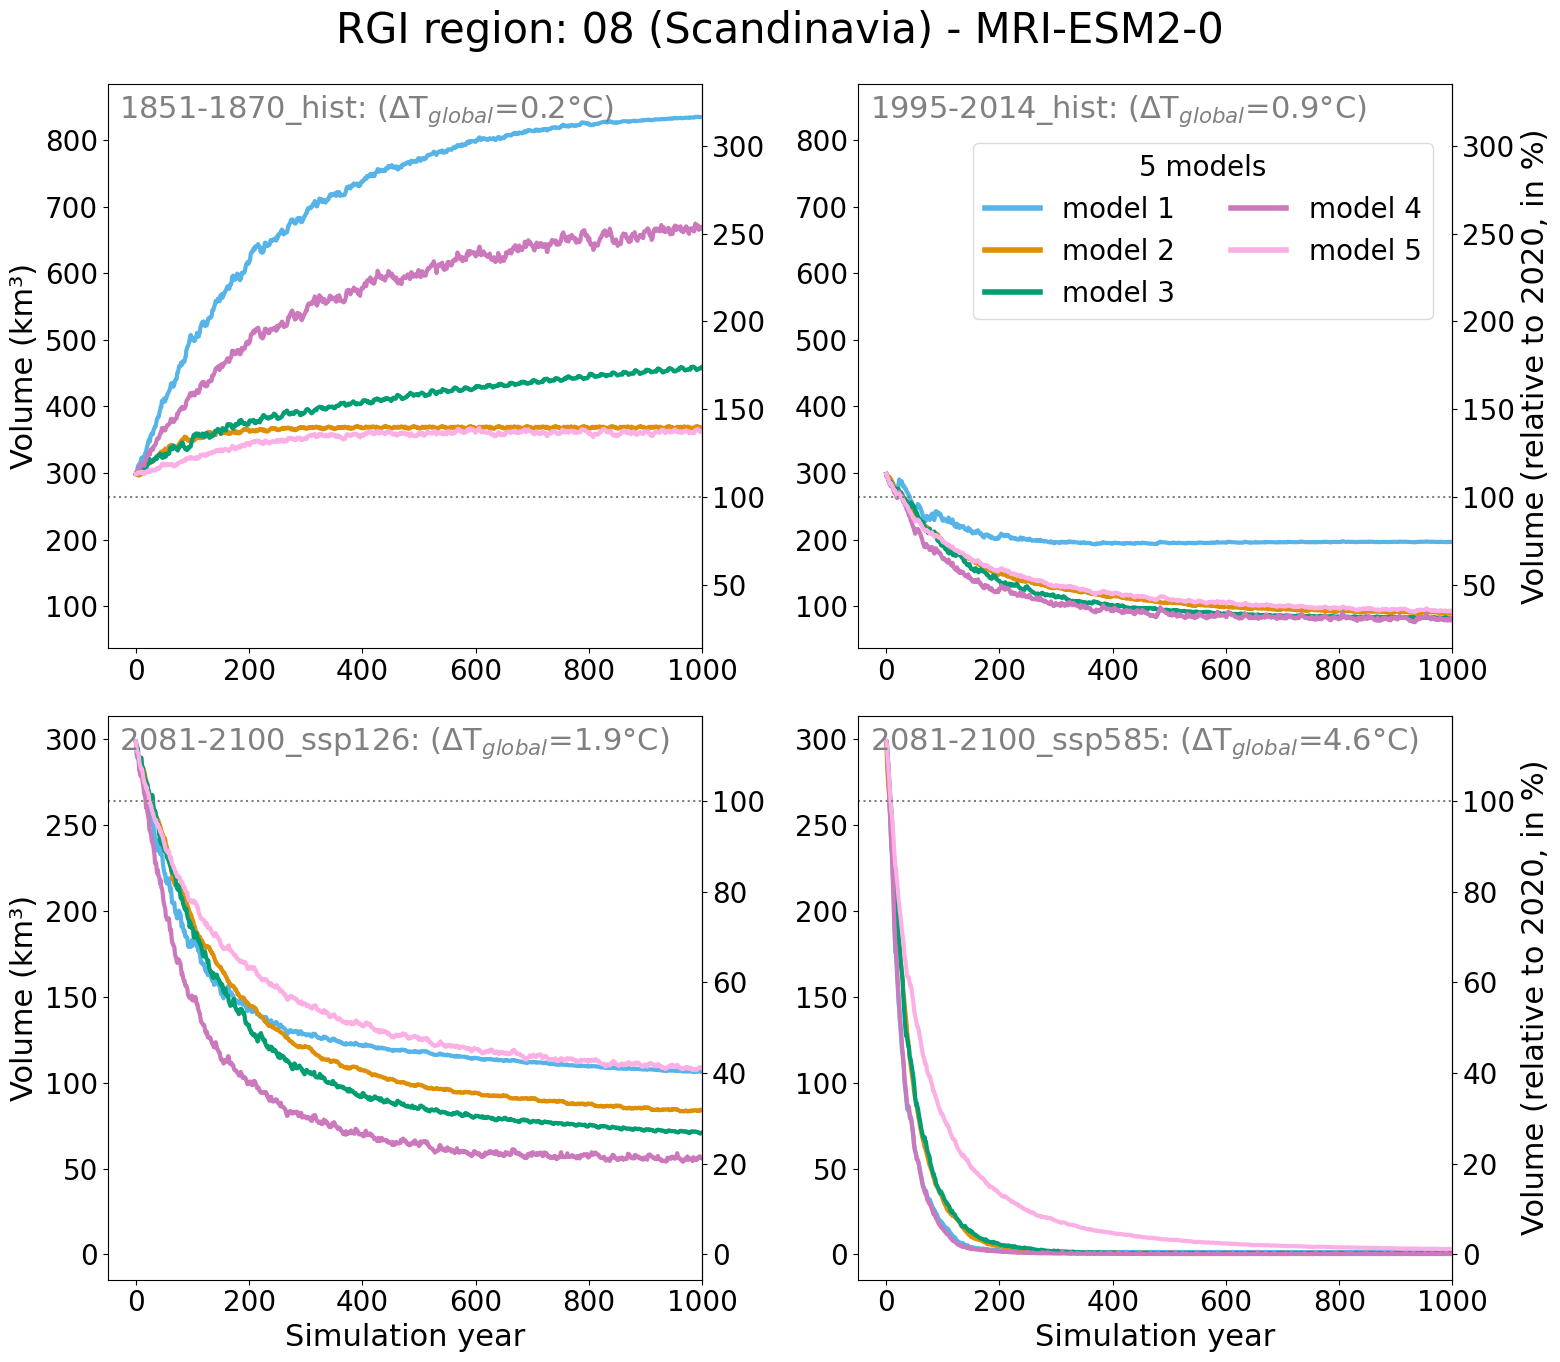

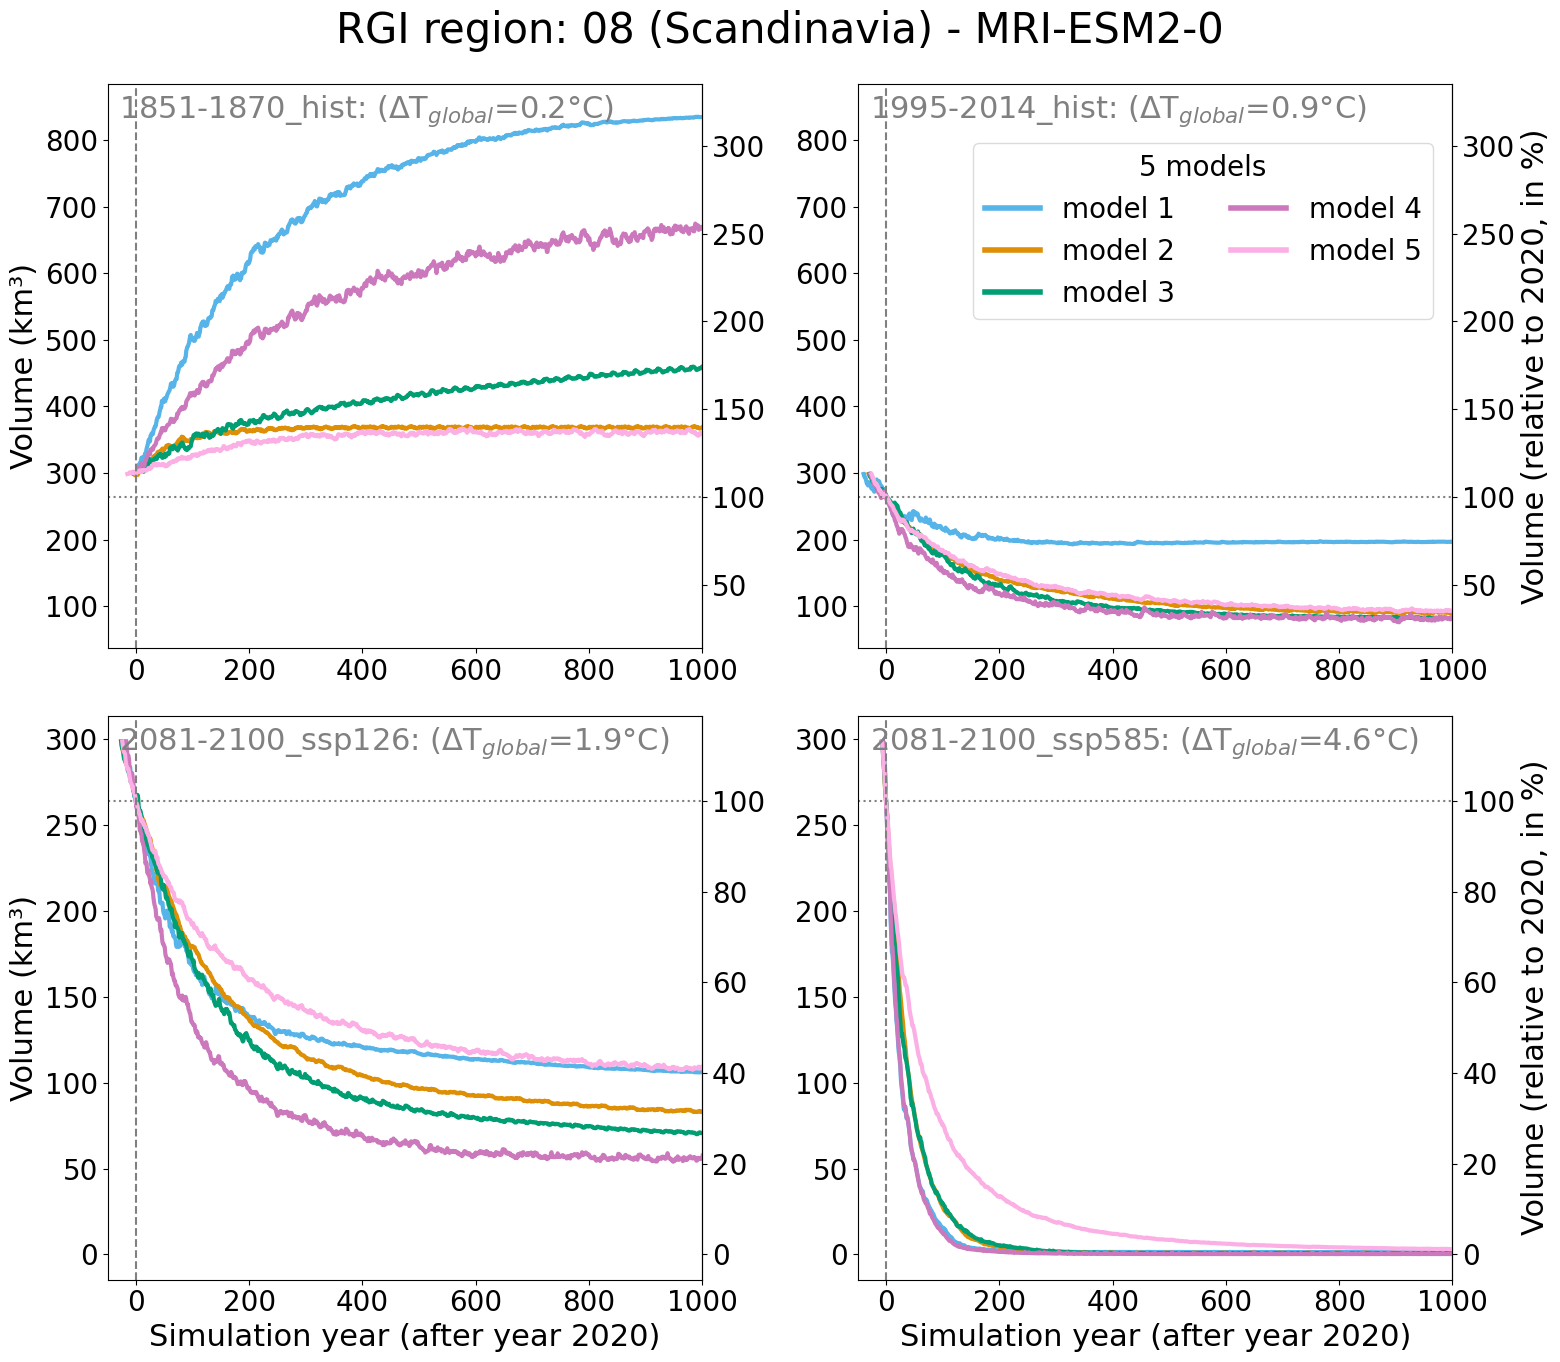

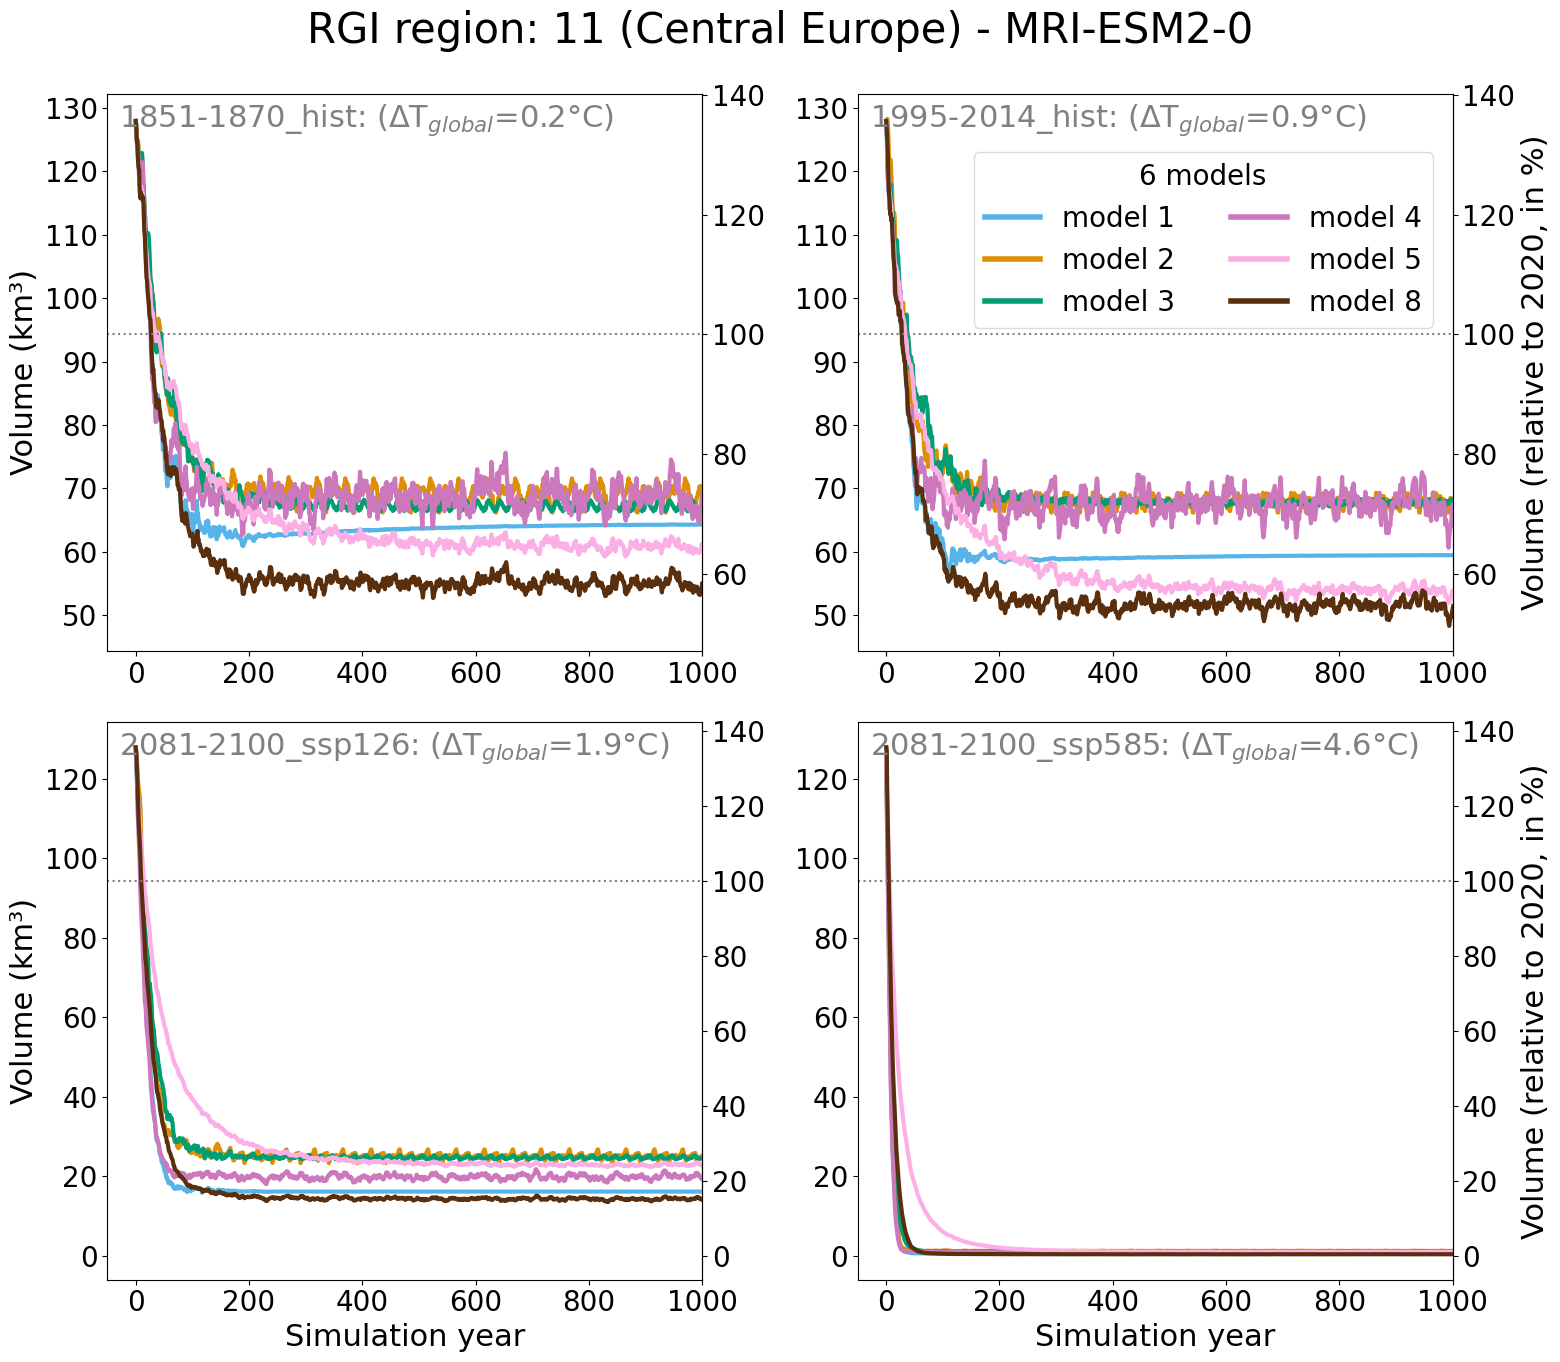

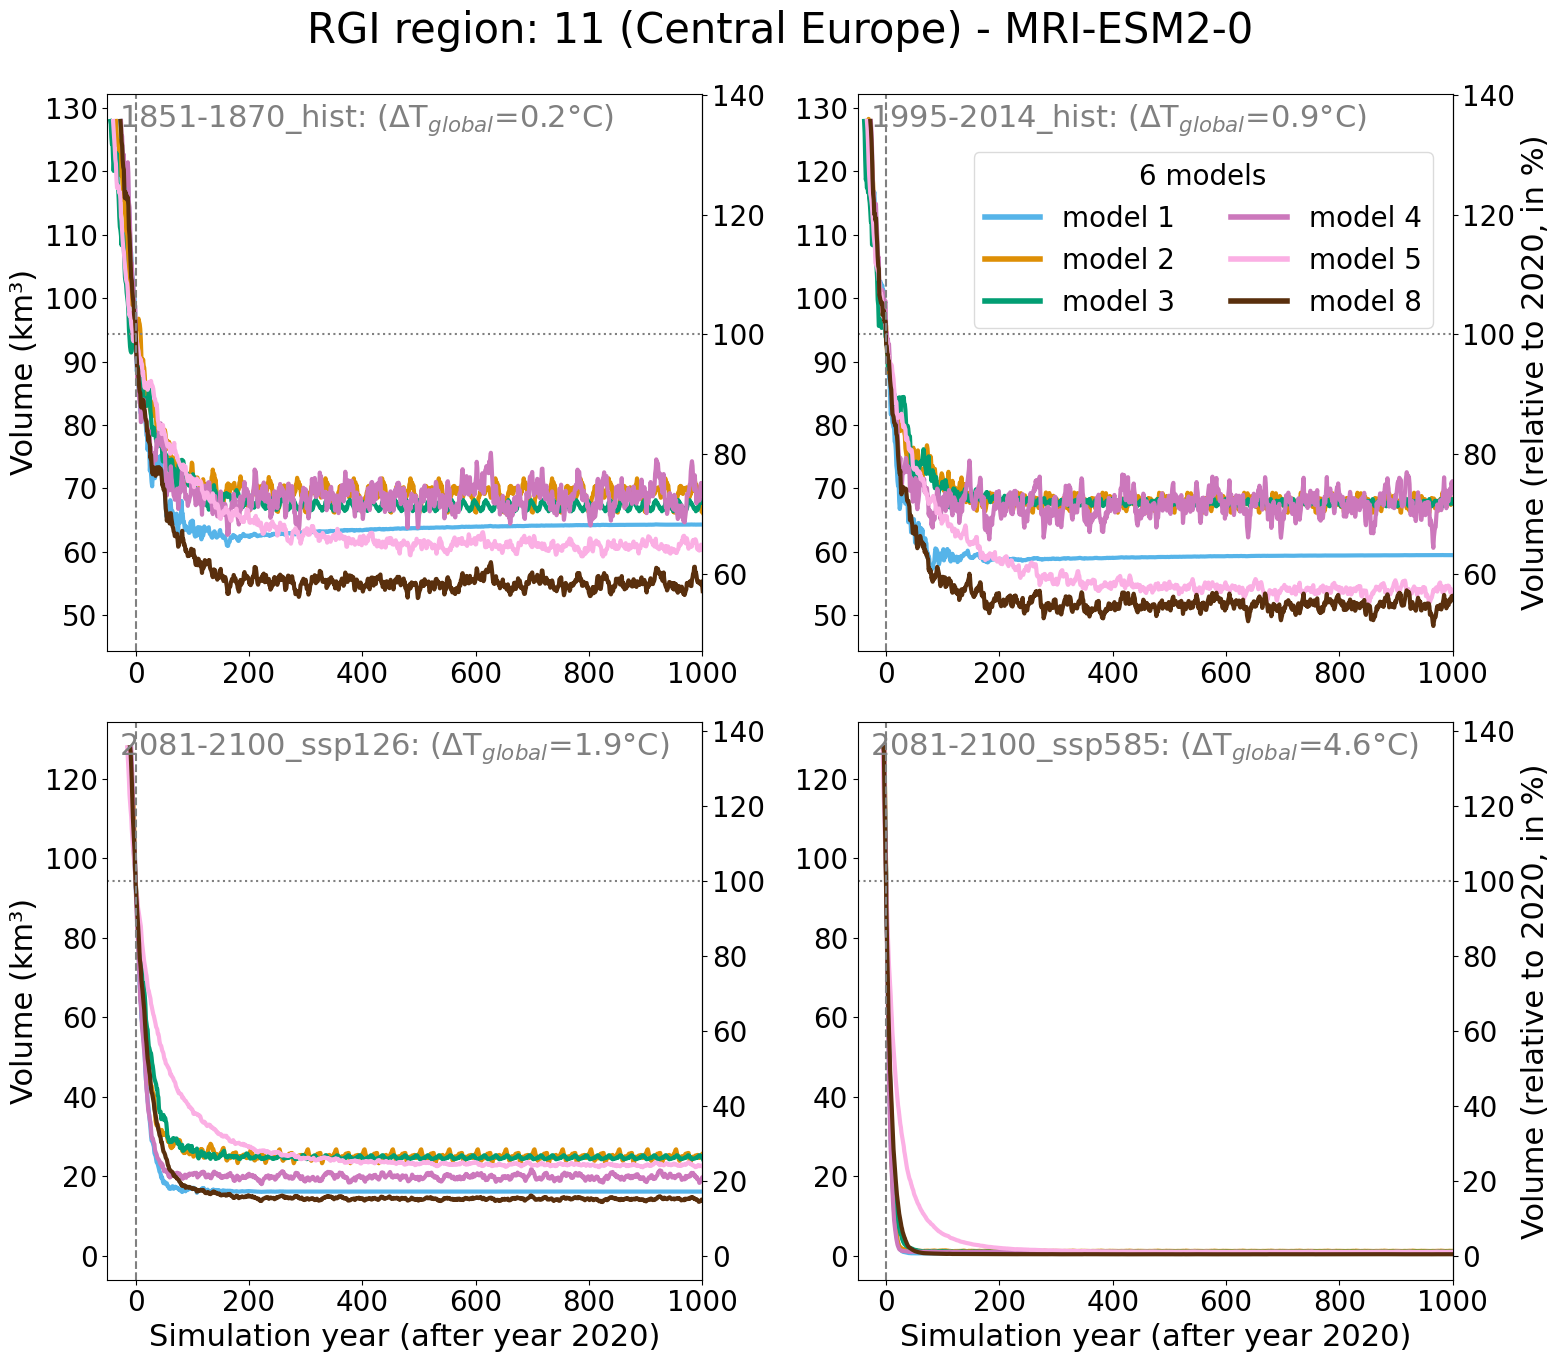

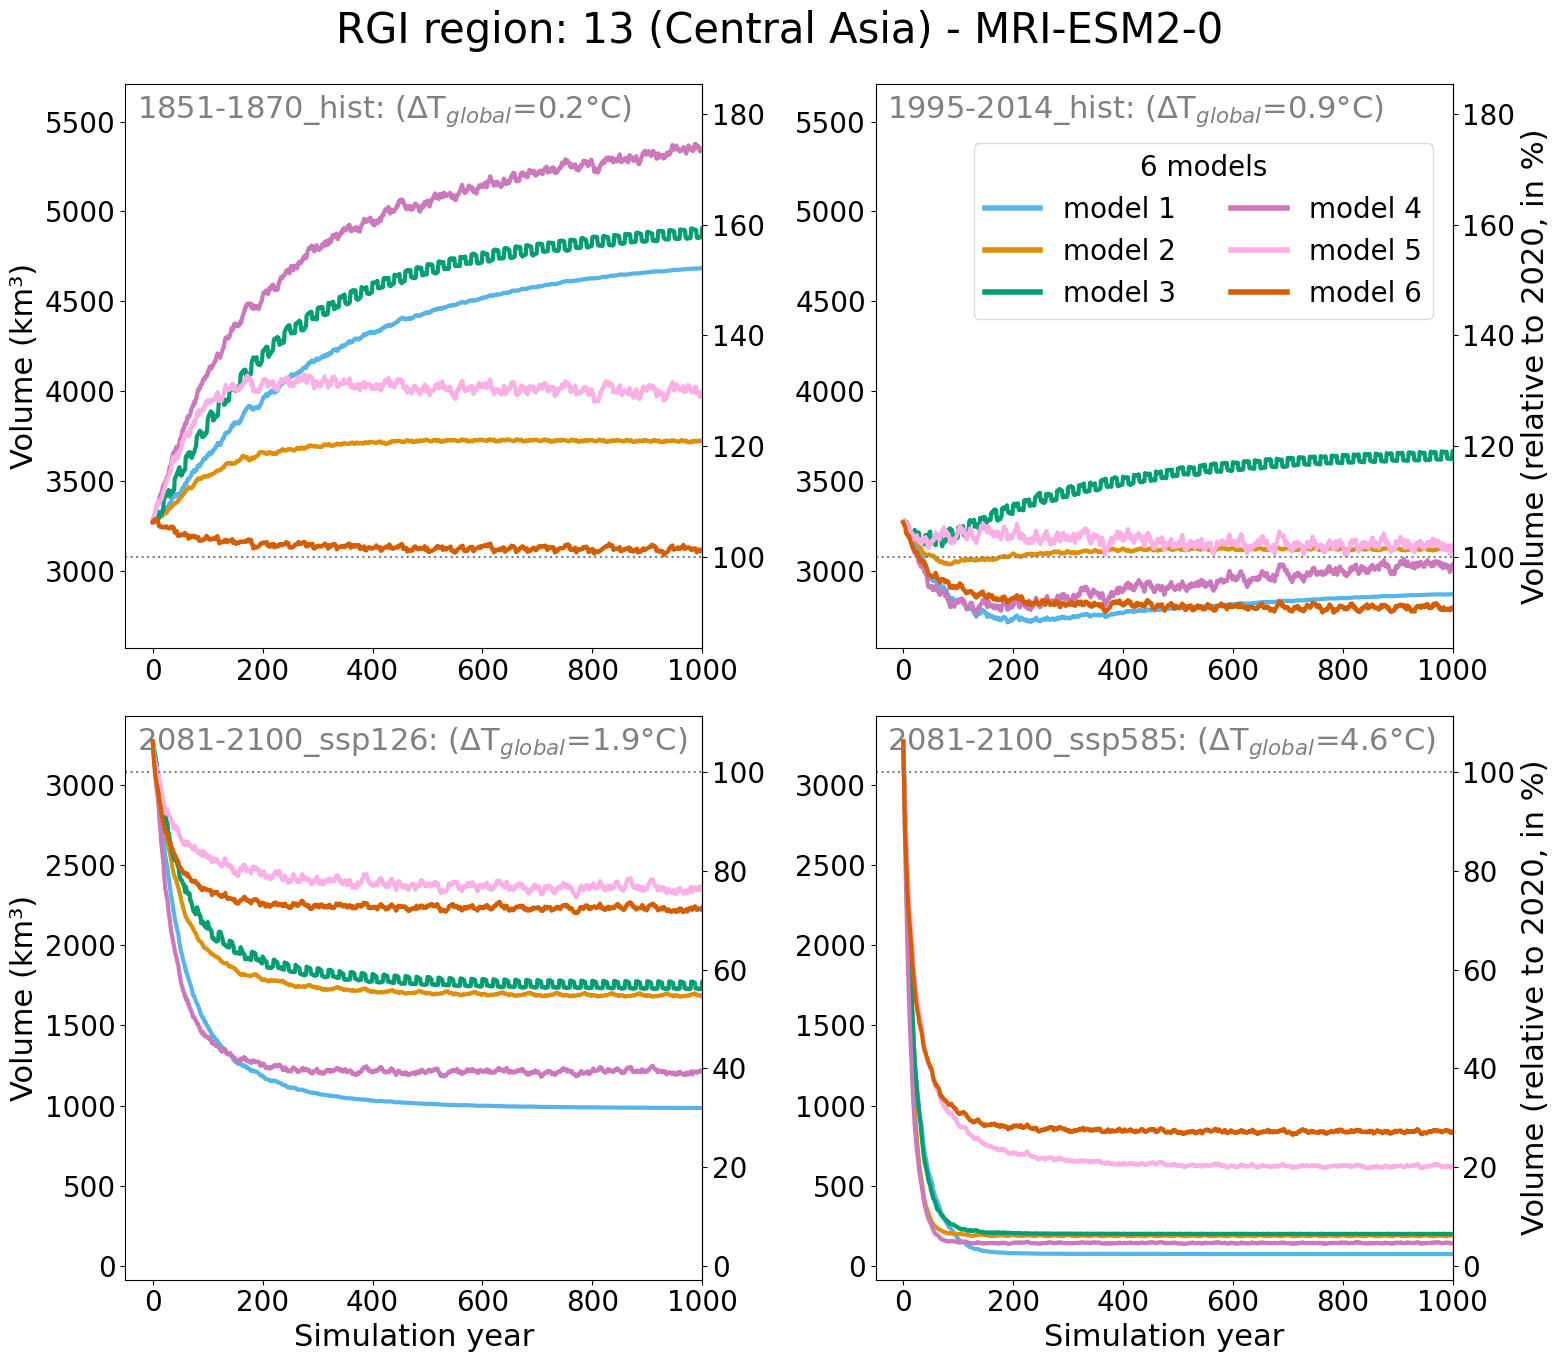

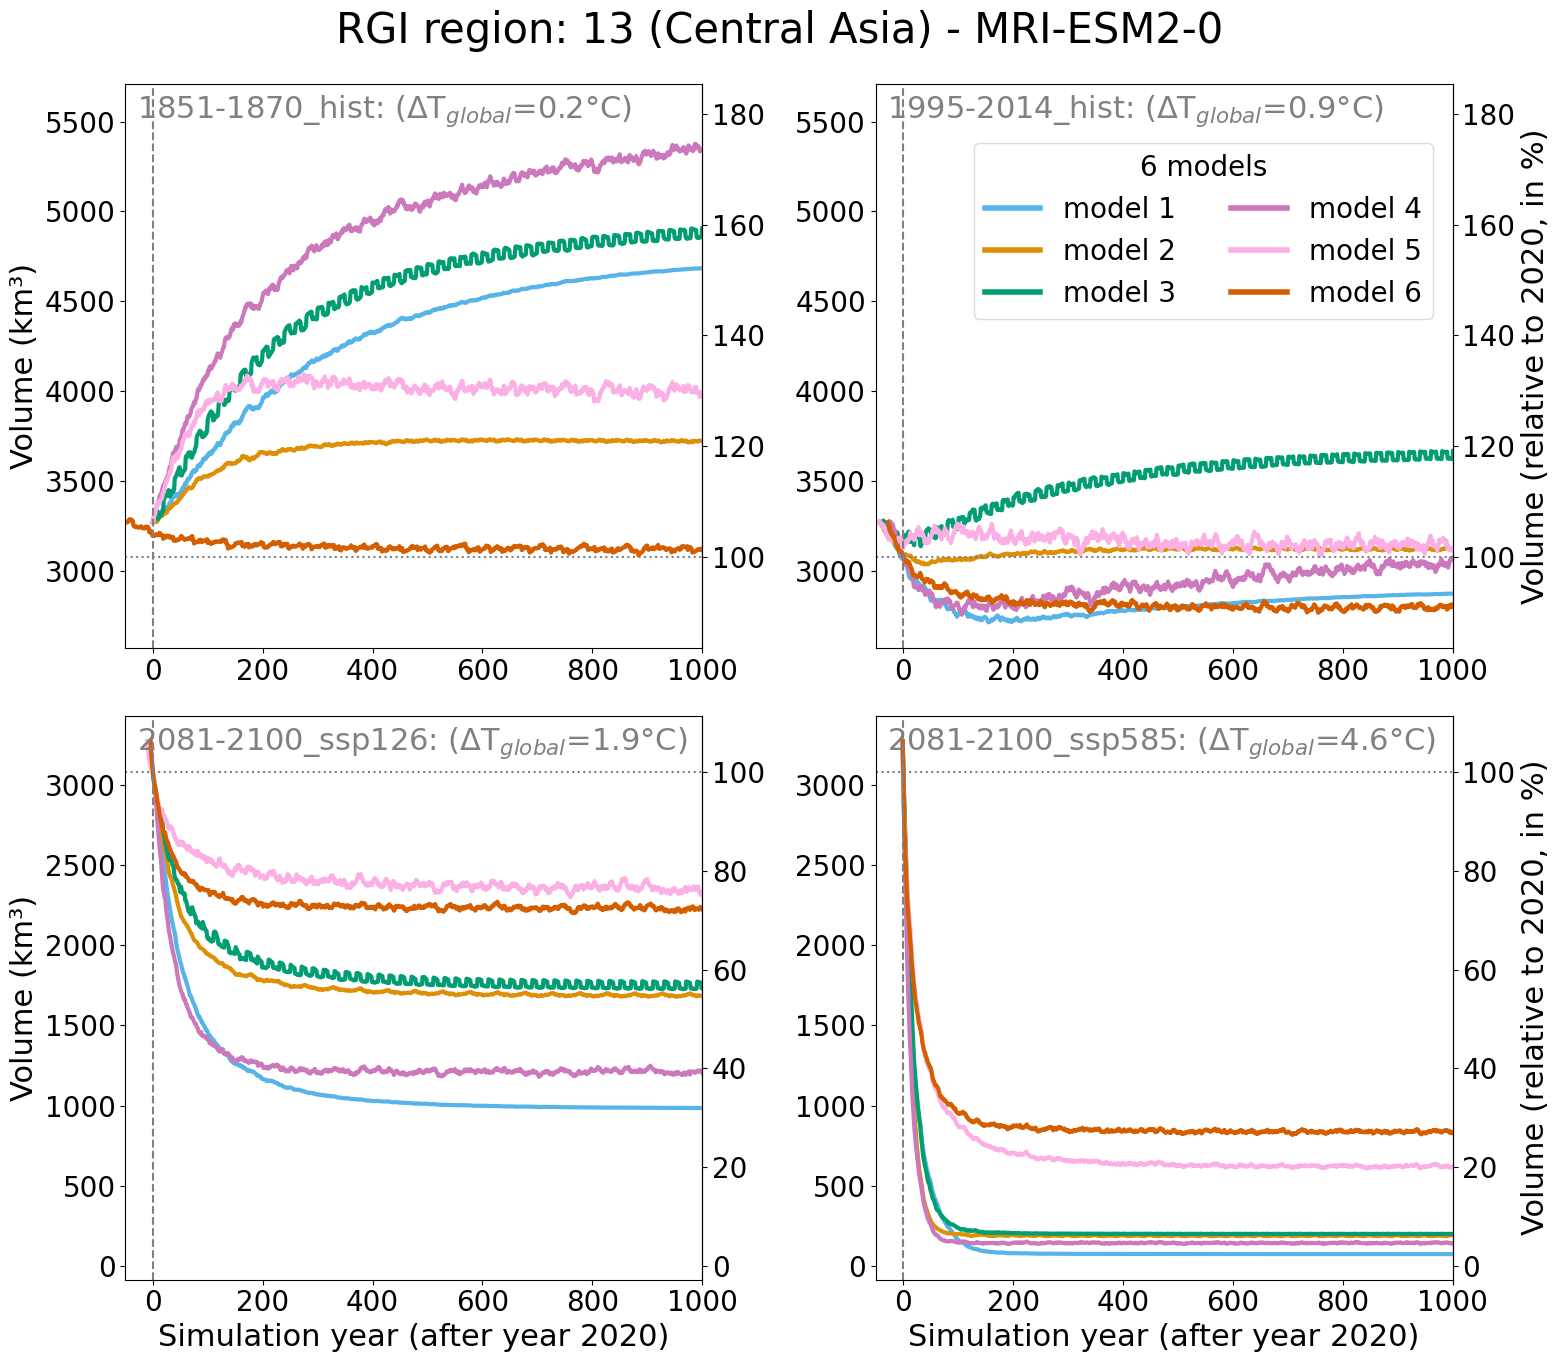

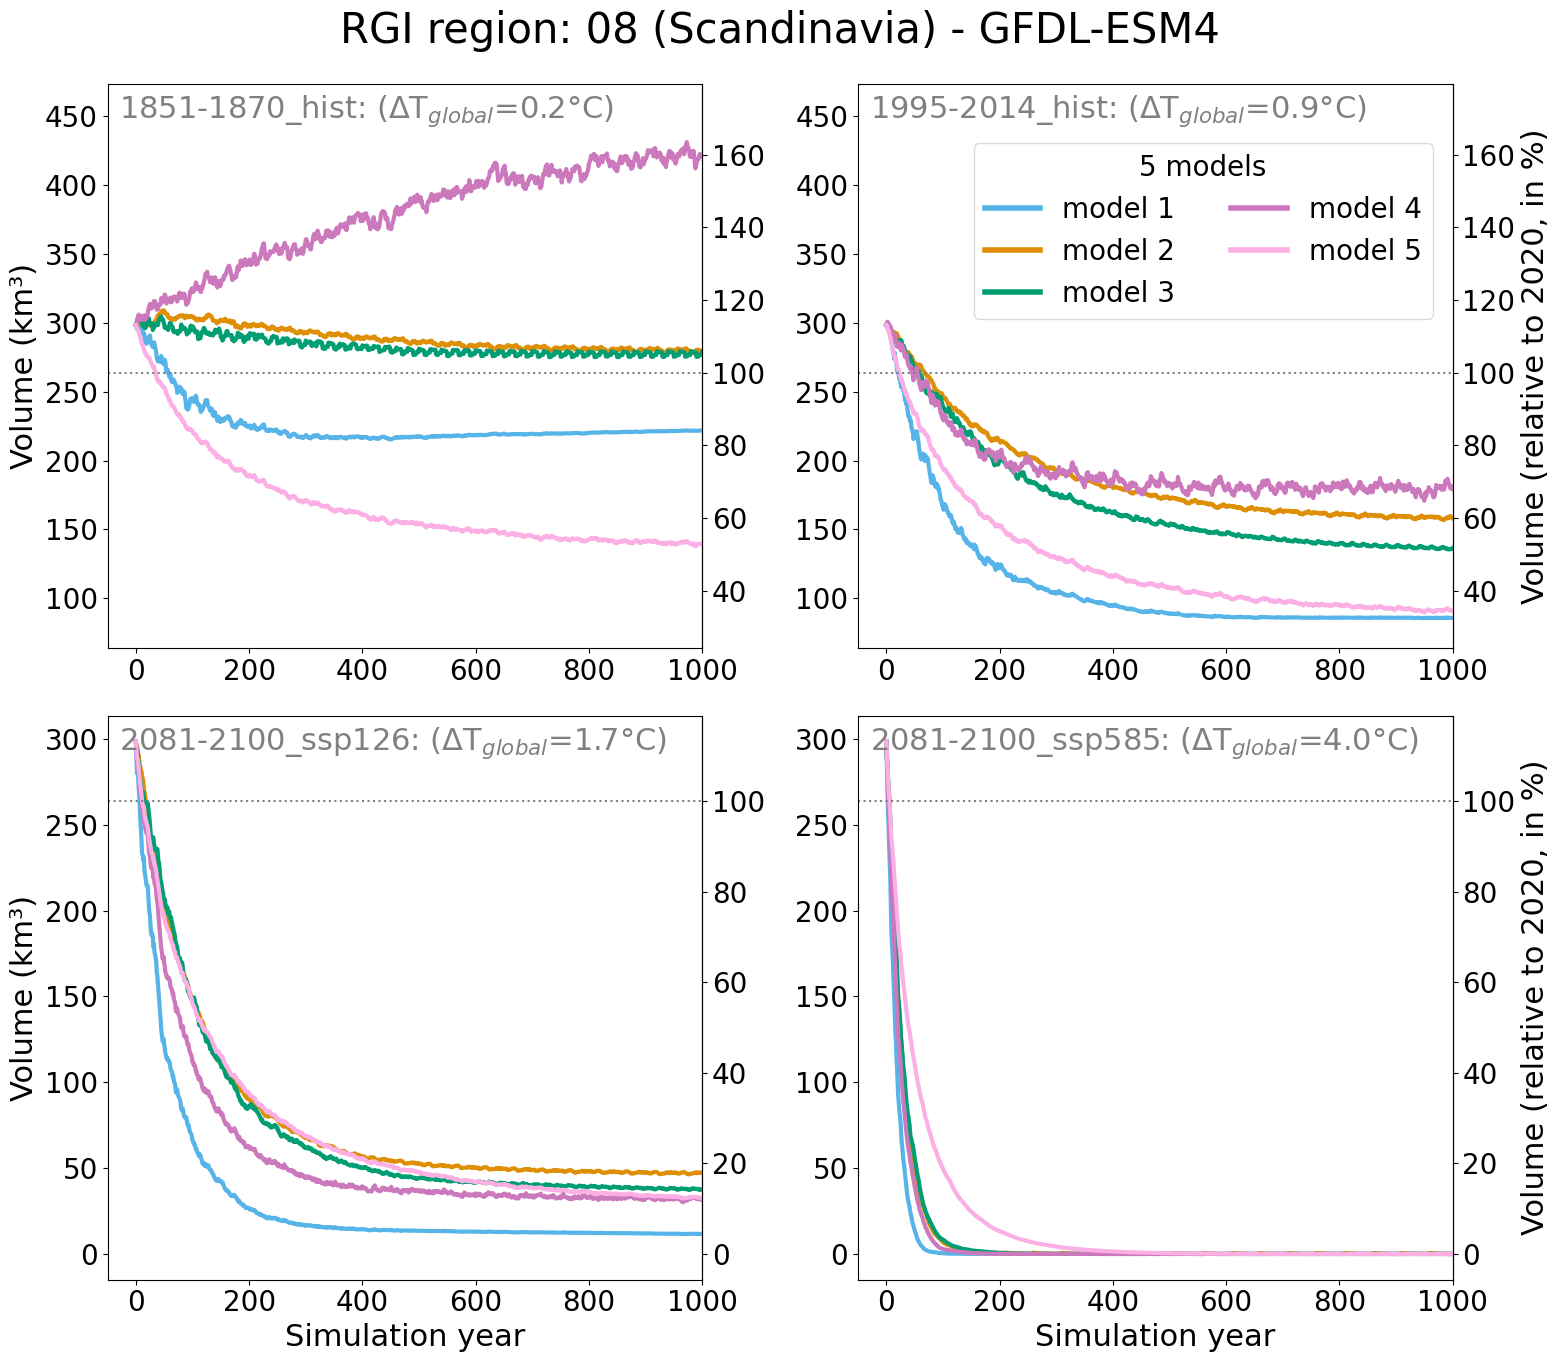

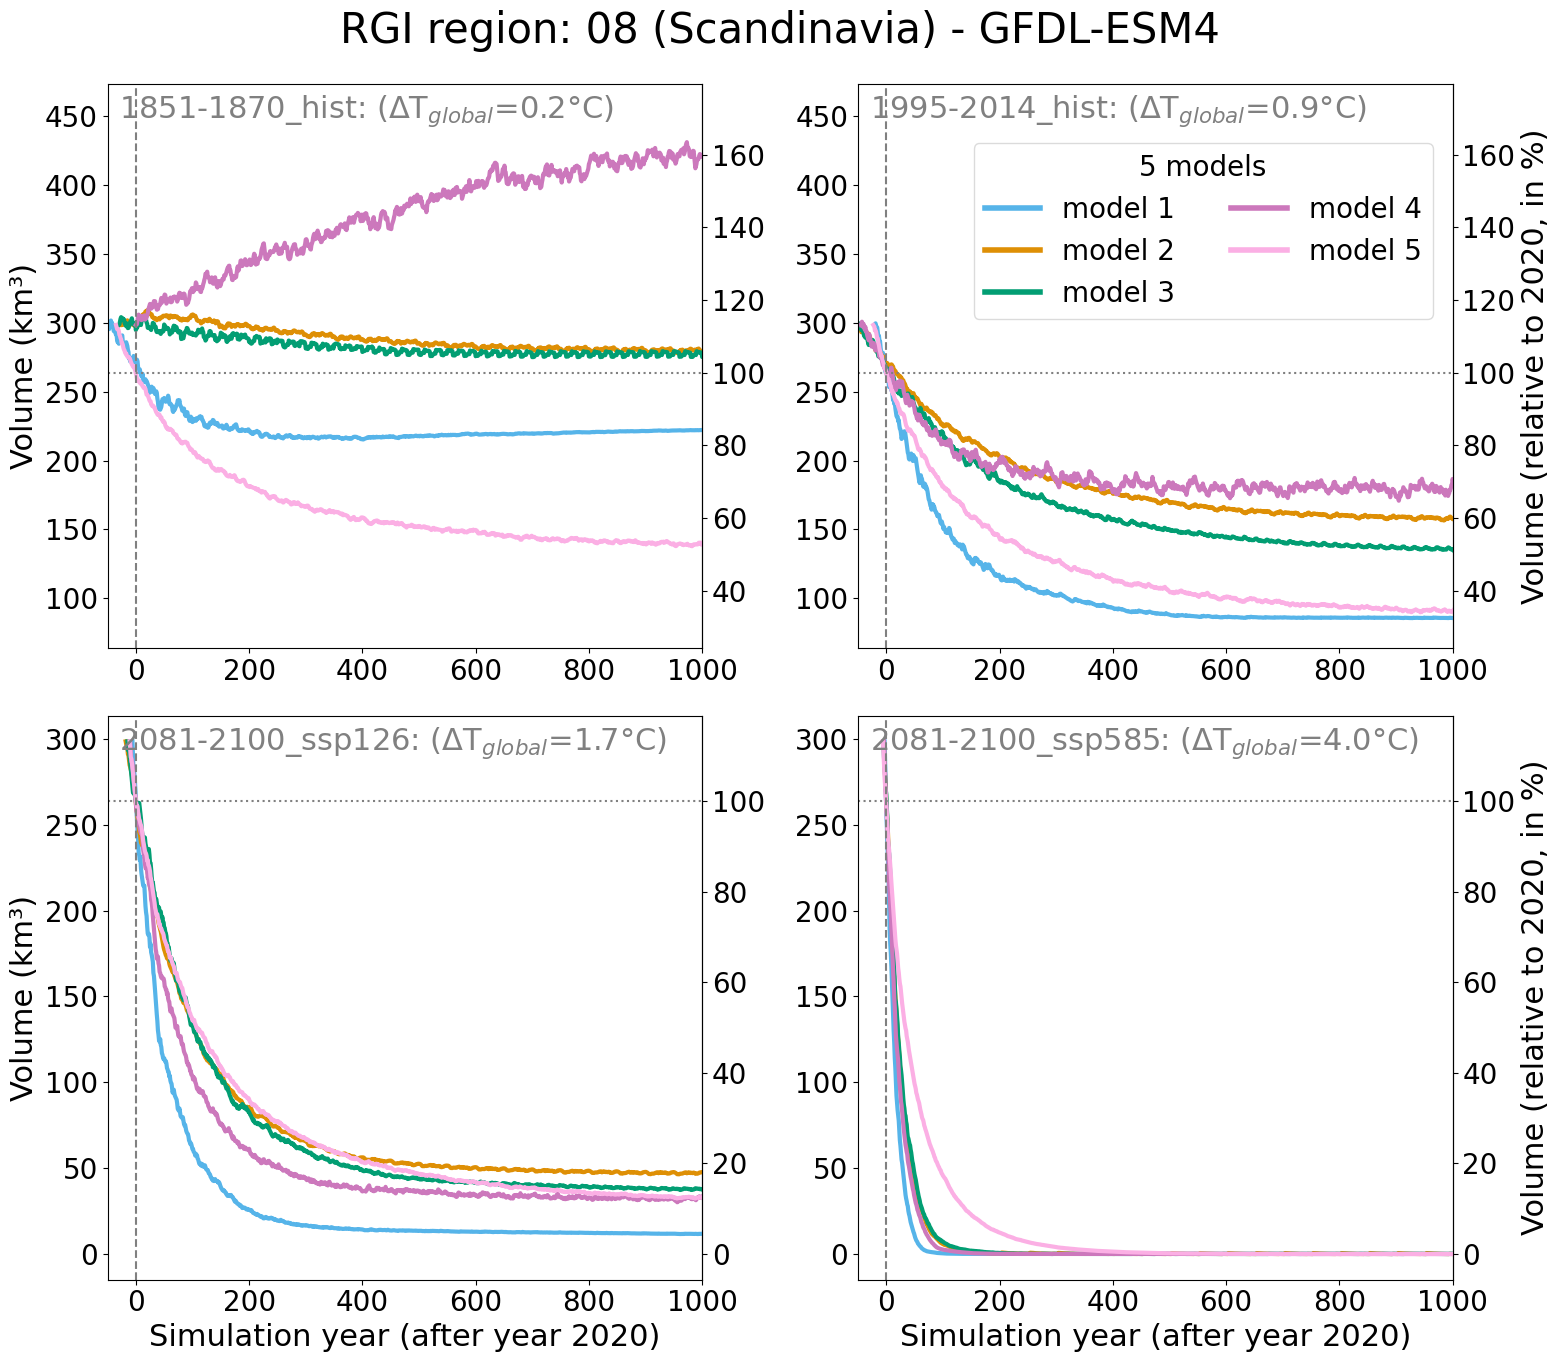

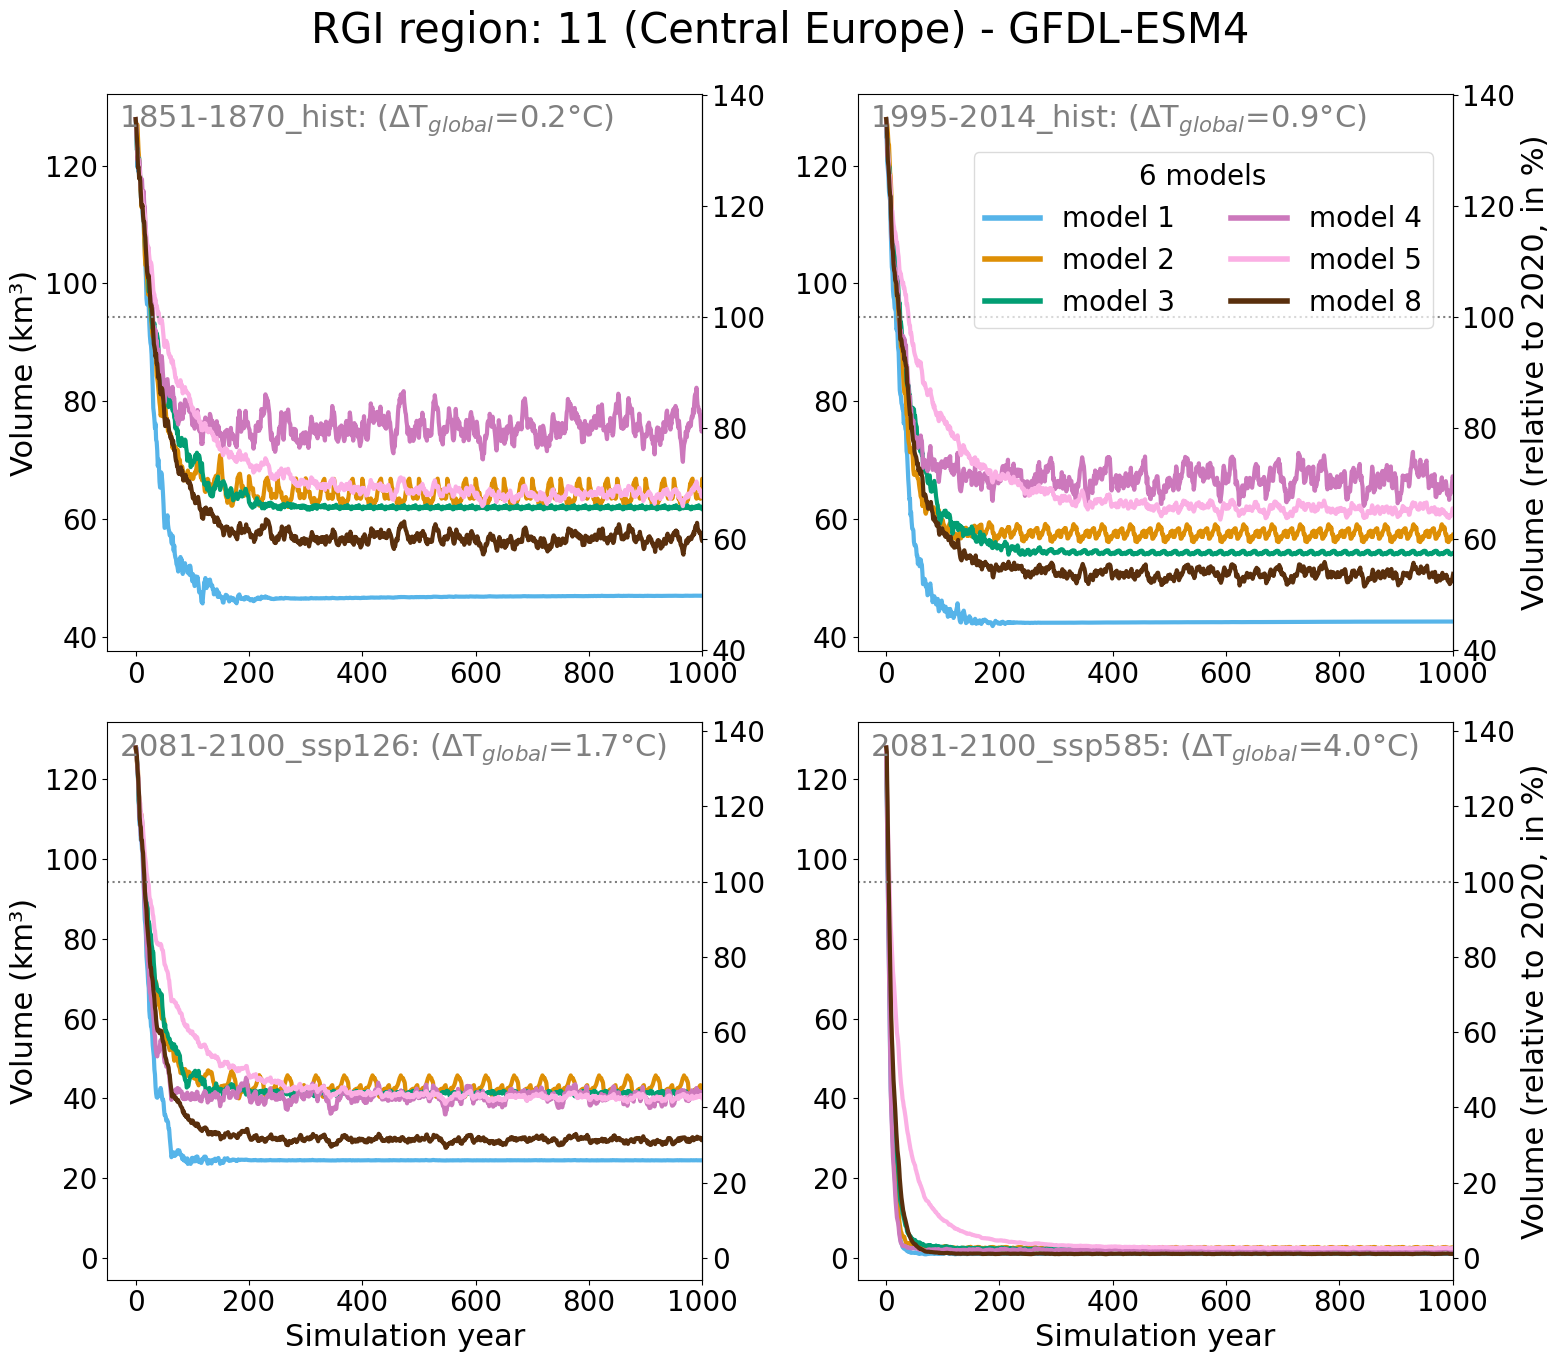

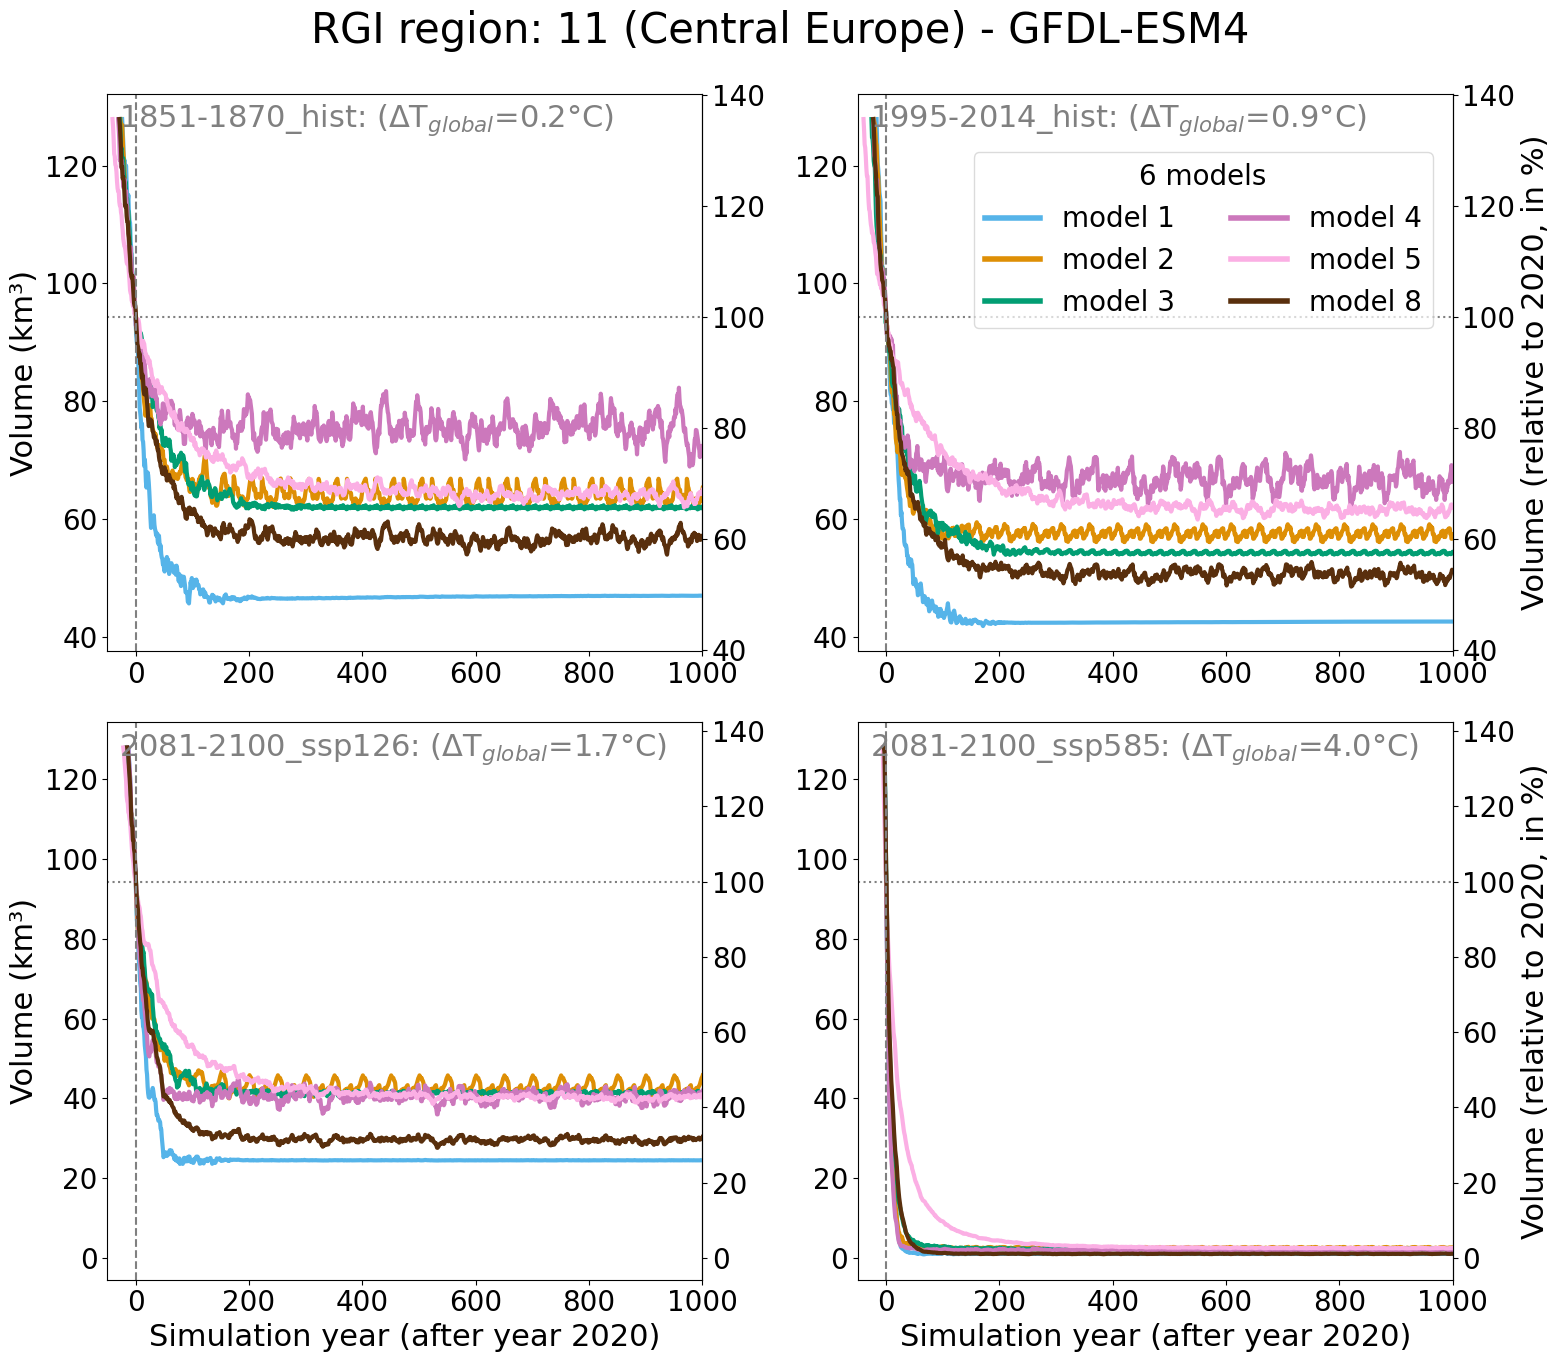

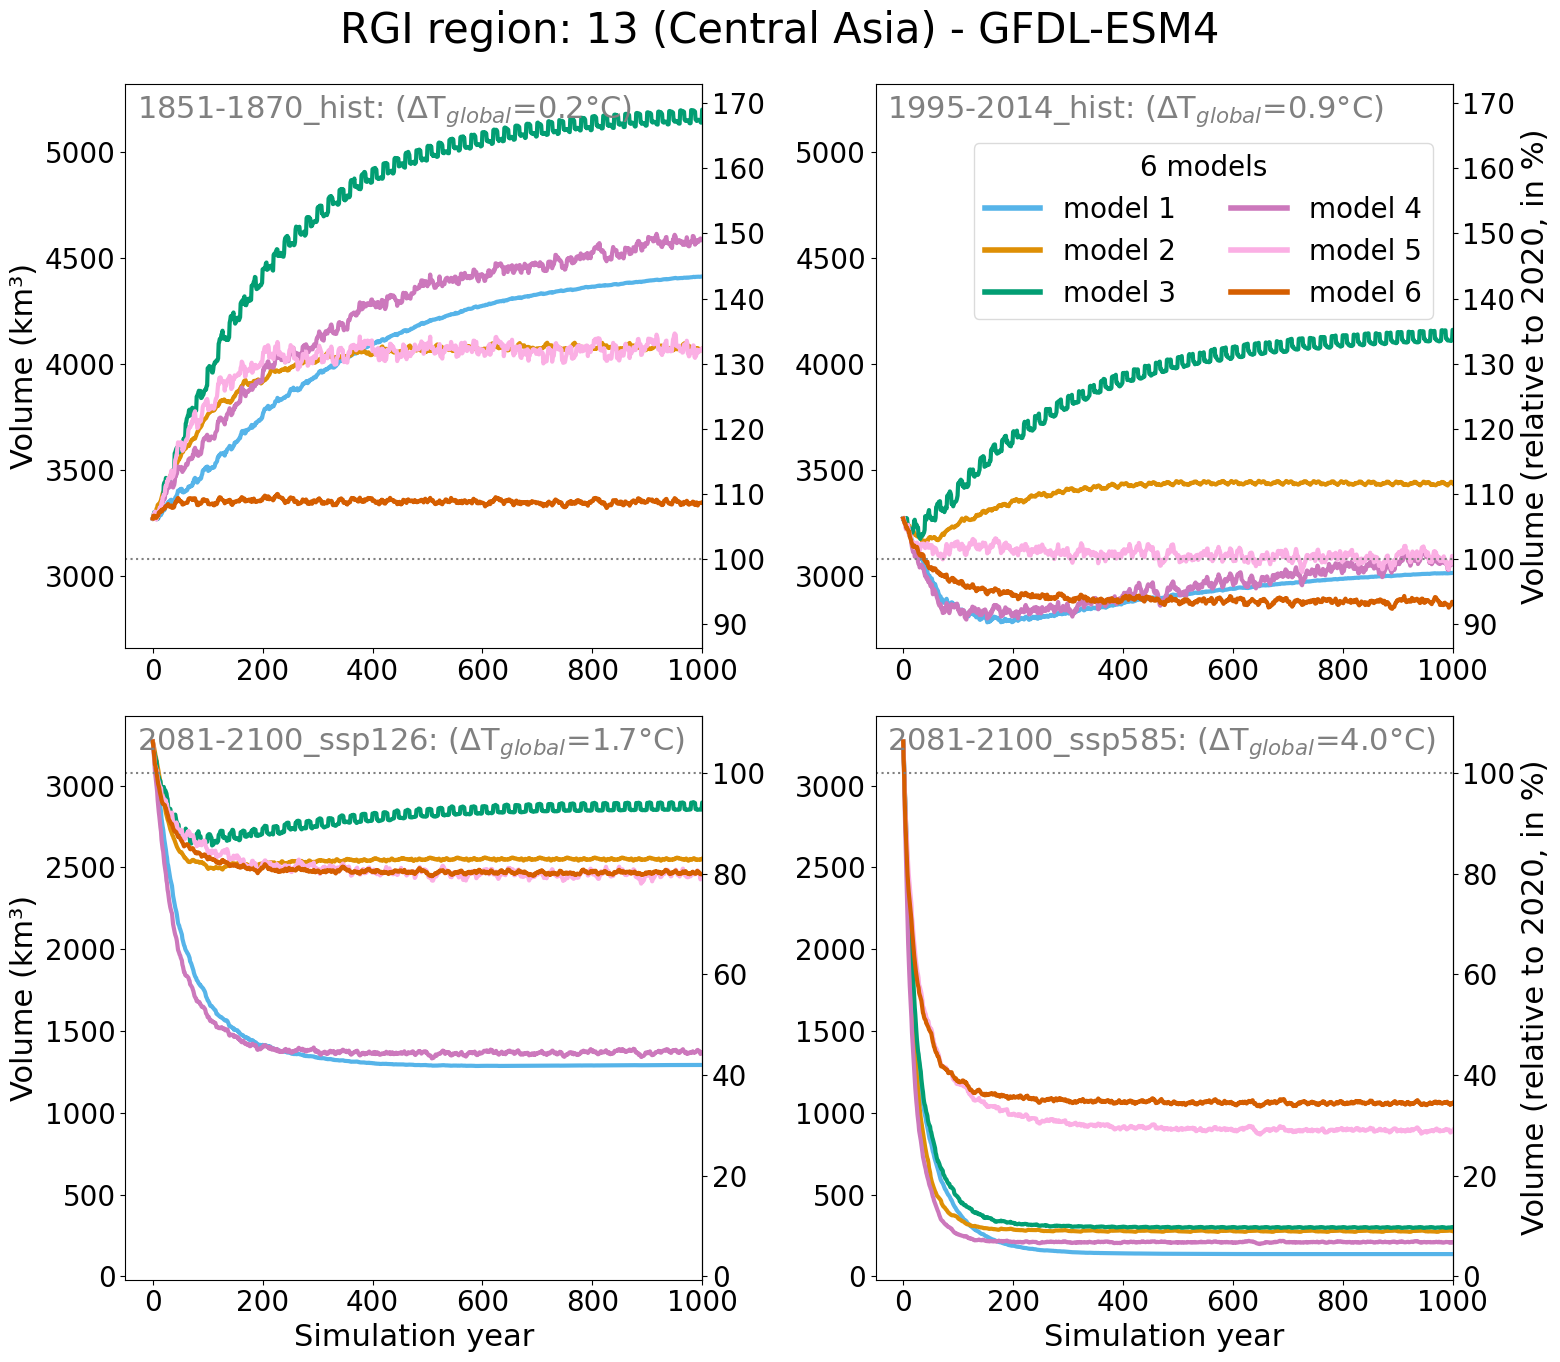

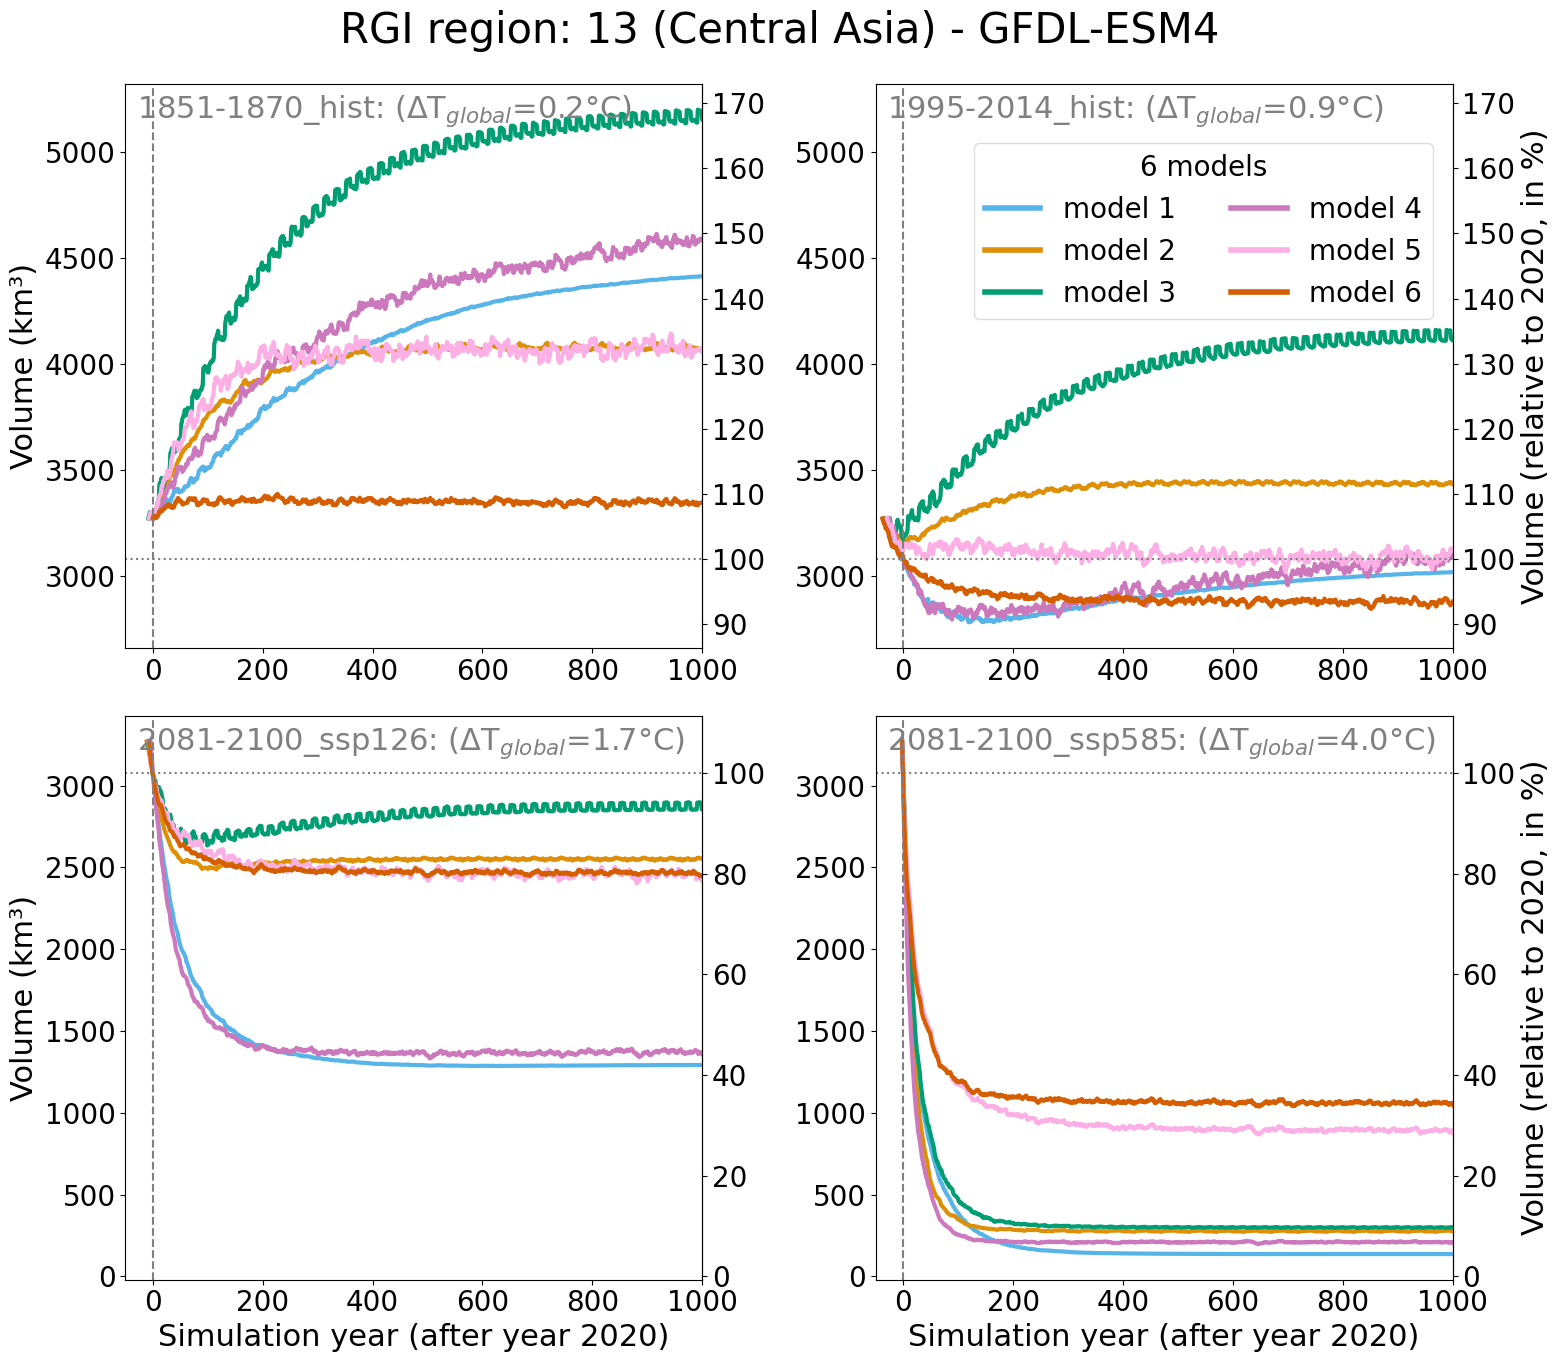

In [13]:
pd_rgi_stats_w_hugonnet = pd.read_csv(f'rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv', index_col = [0])

ls = 'solid'
sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
for anonym in ['_anonym']: #'', 
    for gcm in ['mri-esm2-0','gfdl-esm4']:
        #for rgi_reg in ['11']:
        for rgi_reg in ['08','11','13']:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
            def vol_rel_2020_to_vol_km3(x, _vol_2020_reg = vol_2020_reg):
                return x*_vol_2020_reg/1e9/100
            def vol_km3_to_vol_rel_2020(x, _vol_2020_reg = vol_2020_reg):
                return x*1e9*100/_vol_2020_reg
            for shift in [False, True]: 
                if shift:
                    _ds_reg_models = ds_reg_yr_shift
                    xx = 'year_after_2020'
                else:
                    _ds_reg_models = ds_reg_models
                    xx = 'simulation_year'
                plt.figure(figsize=(16,14))
                axs = []
                for j,period_scenario in enumerate(sel_periods):
                    condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                    temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()
                    if j==0 or j==2:
                        ax0=plt.subplot(2,2,j+1)
                        ax = ax0
                    else:
                        ax=plt.subplot(2,2,j+1, sharey=ax0)
                    axs.append(ax)

                    pd_reg_vol_sel = _ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                    pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                    pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                    # to get a legend with only the model authors of that RGI region
                    models_reg = pd_reg_vol_sel.model_author.unique()
                    dict_model_col_reg = {}
                    list_reg_model_anonym = []
                    for h, p in zip(hue_order,pal_models):
                        if h in models_reg:
                            dict_model_col_reg[h]= p
                            list_reg_model_anonym.append(model_order_anonymous[h])
                            
                    if ls == 'solid' and j==3:
                        sns.lineplot(x=xx, data=pd_reg_vol_sel, y='volume (km³)',
                                 hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=True, lw=3, ax=ax)
                    else:
                        sns.lineplot(x=xx, data=pd_reg_vol_sel, y='volume (km³)',
                                 hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=True, lw=3, ax=ax)

                    # add runaway effect
                    #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                    #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                    #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                    #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                    #             alpha =1)

                    if j in [0,2]:
                        plt.ylabel('Volume (km³)', fontsize=22)
                    else:
                        plt.ylabel('')
                    if shift:
                        plt.xlabel('Simulation year (after year 2020)', fontsize=22)
                    else:
                        plt.xlabel('Simulation year', fontsize=22)

                    ax.set_xlim([-50,1000])
                    if j==1:
                        minip, maxip = ax.get_ylim()
                    elif j==3:
                        minif, maxif = ax.get_ylim()
                
                    ax2 = ax.secondary_yaxis(1., functions=(vol_km3_to_vol_rel_2020, 
                                             vol_rel_2020_to_vol_km3))

                    if j in [1,3]:
                        ax2.set_ylabel('Volume (relative to 2020, in %)', fontsize=22)
                    else:
                        ax2.set_ylabel('')
     
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    if j==1: 
                        n = len(models_reg)
                        if anonym:
                            leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                            bbox_to_anchor=(0.99,0.92))
                        else:
                            leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                        for legobj,c in zip(leg.legendHandles, list(dict_model_col_reg.values())):
                            legobj.set_linewidth(4.0)
                            legobj.set_color(c)
                        leg.set_zorder = 5                        

                    #leg.set_bbox_to_anchor([1,1])
                    ax.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                            fontsize=22, transform=ax.transAxes, zorder=6)

                    if j<2:
                        #ax2.set_ylim([minip*rel,maxip*rel])
                        ax.set_xlabel('')
                    ax.axhline(vol_rel_2020_to_vol_km3(100),ls=':', color='grey')
                    if shift == True:
                        ax.axvline(0,ls='--', color='grey')
                        
                reg = d_reg_num_name[rgi_reg]
                plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
                plt.tight_layout()

                plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_shift{shift}{DATE}.png')


In [14]:
ls = 'solid'
for shift in [False, True]: 
    if shift:
        _ds_reg_models = ds_reg_yr_shift
        xx = 'year_after_2020'
        xlabel = 'Simulation year (after year 2020)'
    else:
        _ds_reg_models = ds_reg_models
        xx = 'simulation_year'
        xlabel = 'Simulation year'
    for anonym in ['', '_anonym']:
        for gcm in _ds_reg_models.gcm.values:
            #for rgi_reg in ['11']:
            for rgi_reg in rgi_regs:
                vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
                def vol_rel_2020_to_vol_km3(x, _vol_2020_reg = vol_2020_reg):
                    return x*_vol_2020_reg/1e9/100
                def vol_km3_to_vol_rel_2020(x, _vol_2020_reg = vol_2020_reg):
                    return x*1e9*100/_vol_2020_reg
                plt.figure(figsize=(30,30))
                axs = []
                for j,period_scenario in enumerate(_ds_reg_models.period_scenario):
                    condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                    temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()

                    if j==0 or j==4:
                        ax0=plt.subplot(4,4,j+1)
                        ax = ax0
                    else:
                        ax=plt.subplot(4,4,j+1,sharey=ax0)
                    axs.append(ax)

                    pd_reg_vol_sel = _ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                    pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                    pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                    models_reg = pd_reg_vol_sel.model_author.unique()
                    dict_model_col_reg = {}
                    list_reg_model_anonym = []
                    for h, p in zip(hue_order,pal_models):
                        if h in models_reg:
                            dict_model_col_reg[h]= p
                            list_reg_model_anonym.append(model_order_anonymous[h])
                    if ls == 'solid' and j==3:
                        sns.lineplot(x=xx, data=pd_reg_vol_sel, y='volume (km³)',
                                 hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(),
                                     ls=ls, legend=True, lw=3, ax=ax)
                    else:
                        sns.lineplot(x=xx, data=pd_reg_vol_sel, y='volume (km³)',
                                 hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(),
                                     ls=ls, legend=True, lw=3, ax=ax)


                    #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                    #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                    #             alpha =1)

                    if j in [0,4,8,12]:
                        plt.ylabel('Volume (km³)', fontsize=22)
                    else:
                        plt.ylabel('')
                    plt.xlabel(xlabel, fontsize=22)

                    ax.set_xlim([-100,2000])
                    if j==3:
                        minip, maxip = ax.get_ylim()
                    elif j==15:
                        minif, maxif = ax.get_ylim()
                    ax2 = ax.secondary_yaxis(1., functions=(vol_km3_to_vol_rel_2020, 
                                                                 vol_rel_2020_to_vol_km3))

                    if j in [3,7,11,15]:
                        ax2.set_ylabel('Volume (relative to 2020, in %)', fontsize=22)
                    else:
                        ax2.set_ylabel('')

                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()    
                    if j==3: 
                        n = len(models_reg)
                        if anonym:
                            leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                            bbox_to_anchor=(0.99,0.92))
                        else:
                            leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                        for legobj,c in zip(leg.legendHandles,
                                            list(dict_model_col_reg.values())):
                            legobj.set_linewidth(4.0)
                            legobj.set_color(c)
                        leg.set_zorder = 5     

                    #leg.set_bbox_to_anchor([1,1])
                    ax.text(0.02,0.96, str(period_scenario.values) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                                fontsize=20, transform=ax.transAxes, zorder=6)
                    ax.axhline(vol_rel_2020_to_vol_km3(100),ls=':', color='grey')
                    if shift == True:
                        ax.axvline(0,ls='--', color='grey')
                    #rel = 100*1e9/sel_ds_reg_model_vol.sel(year_after_2020=0)
                    #rel = rel.dropna(dim='model_author')
                    #np.testing.assert_allclose(rel[0], rel, rtol=1e-2)
                    #rel = rel[0].values

                    #if j<4:
                    #    ax2.set_ylim([minip*rel,maxip*rel])
                    #else:
                    #    ax2.set_ylim([minif*rel,maxif*rel])
                    if j<12:
                        ax.set_xlabel('')
                reg = d_reg_num_name[rgi_reg]
                plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
                plt.tight_layout()

                plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_shift{shift}_{DATE}.png')
                plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_shift{shift}_{DATE}.pdf')
                plt.close()

### TODO --- CHecks if stead-state is reached (NOT YET UPDATED) --> THIS IS OLD AND e.g. not updated with IPCC AR6 stuff ... 

In [19]:
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
init_vol = ds_reg_models_vol.isel(simulation_year=0)



----

**Xarray bug issue detection**

In [33]:
avg_yrs=20
min_periods=20
m = 'GLIMB'
_s_m = (ds_reg_models_vol/init_vol).sel(rgi_reg=rgi_reg).sel(model_author=m).dropna(dim='simulation_year')

ds_sel = 100*_s_m.rolling(simulation_year=avg_yrs, center=True, min_periods=min_periods).mean()

In [47]:
ds_sel = 100*_s_m.rolling(simulation_year=100, center=True, min_periods=20).mean()
ds_sel2 = 100*_s_m.rolling(simulation_year=50, center=True, min_periods=50).mean()
ds_sel3 = 100*_s_m.rolling(simulation_year=100, center=True).mean()
ds_selx = 100*_s_m.isel(experiments=0).rolling(simulation_year=50, min_periods=20).mean()

In [48]:
ds_sel2.dropna(dim='simulation_year')

<xarray.DataArray 'volume_m3' (simulation_year: 4952, experiments: 80)>
array([[104.56327 , 101.399574, 105.07729 , ...,  78.92724 ,  49.367752,
         42.4345  ],
       [104.78158 , 101.46097 , 105.27552 , ...,  78.29395 ,  47.916298,
         40.84579 ],
       [104.993996, 101.539   , 105.47708 , ...,  77.69415 ,  46.543564,
         39.360382],
       ...,
       [124.84468 , 113.28683 , 123.5843  , ...,  55.84092 ,  10.17624 ,
          6.347741],
       [124.819756, 113.312935, 123.58563 , ...,  55.838127,  10.174736,
          6.34616 ],
       [124.82647 , 113.353226, 123.612915, ...,  55.83825 ,  10.172198,
          6.345692]], dtype=float32)
Coordinates:
    model_author     <U5 'GLIMB'
  * simulation_year  (simulation_year) int16 25 26 27 28 ... 4973 4974 4975 4976
    rgi_reg          <U2 '13'
  * experiments      (experiments) MultiIndex
  - gcm              (experiments) object 'gfdl-esm4' ... 'ukesm1-0-ll'
  - period_scenario  (experiments) object '1851-1870_hist' ... '2081-2100_ssp...

In [14]:
100*_s_m.isel(experiments=0).values[:30]

array([100.      , 100.40582 , 100.67107 , 100.77815 , 100.98832 ,
       100.88557 ,  99.875206,  99.8469  , 100.03431 , 100.32061 ,
       100.33696 , 101.19659 , 101.316666, 101.61756 , 101.56385 ,
       101.72028 , 102.33699 , 102.1872  , 103.023674, 103.17317 ,
       103.41259 , 103.42524 , 103.72656 , 104.592285, 104.74686 ,
       104.70301 , 105.351555, 105.283356, 105.78165 , 105.61372 ],
      dtype=float32)

In [15]:
ds_selx.dropna(dim='simulation_year')

<xarray.DataArray 'volume_m3' (simulation_year: 4982)>
array([101.11395 , 101.22341 , 101.323494, ..., 124.84468 , 124.819756,
       124.82647 ], dtype=float32)
Coordinates:
    model_author     <U5 'GLIMB'
  * simulation_year  (simulation_year) int16 19 20 21 22 ... 4997 4998 4999 5000
    rgi_reg          <U2 '13'
    experiments      object ('gfdl-esm4', '1851-1870_hist')

In [16]:
np.testing.assert_allclose(ds_sel3.sel(simulation_year=slice(50,4950)),
                           ds_sel.sel(simulation_year=slice(50,4950)))

In [54]:
def compute_steady_state_yr(ds_sel, option='relative_to_total_change',
                            threshold_total_change=0, xperc=1, minimum_period=20, test=False):
    
    if len(ds_sel.simulation_year)==0:
        # just set NaN values everywhere
        equilibrium_yr_lower_xperc_ch = pd.DataFrame(index=ds_sel.experiments.to_dataframe().index, 
             columns=['simulation_year'],
             )['simulation_year']
        #print('NaN')
    else:
        end_yr = ds_sel.simulation_year[-1].values
        begin_yr = ds_sel.simulation_year[0].values
        # for the total change, we have to be sure to get a "stable" estimate, thus we
        # use the average over the last 200 years 
        end_state = ds_sel.sel(simulation_year=slice(end_yr-300,end_yr)).mean(dim='simulation_year')
        total_change = np.abs(100 - end_state)  # (Vyr=0 - Yyr steady-state)
        total_change[total_change<threshold_total_change] = np.NaN
        # minimum is 33yrs in region 16, so maybe ok to use a 20-yr average (but normally not a 100-year average)
        testi = ds_sel.sel(simulation_year=slice(minimum_period+begin_yr,end_yr))  # V_yr
        testi_b = ds_sel.sel(simulation_year=slice(begin_yr,end_yr-minimum_period)).values  # V_yr-20/60/100 years
        # important to set here values, as we do not want to substract the same years!!!
        # (V_roll(t) - V_roll(t-50) )/(2*((V_roll(t) + V_roll(t-50) ))
        # v_diff_20_yr = 100*np.abs((testi-testi_b))/(0.5*(testi+testi_b))
        # divide instead by total_change (otherwise we do have a problem if the volume gets very small... )
        # on the other hand, if total chane is small, we also get an issue 
        # v_diff_20_yr = 100*np.abs((testi-testi_b))/total_change
        # lets only do the difference 
        # ??? should we divide by the total change ???
        if option =='relative_to_total_change':
            v_diff_avg_yrs = 100*np.abs((testi-testi_b))/total_change
        elif option == 'relative_to_initial_state':
            v_diff_avg_yrs = np.abs((testi-testi_b))

        v_diff_avg_yrs = v_diff_avg_yrs.reset_coords()

        if test:
            v_diff_avg_yrs_abovexperc = v_diff_avg_yrs.volume_m3.where(np.abs(testi-testi_b)>xperc).to_dataframe(f'volume_diff_after_XX_yrs').dropna()
        else:
            v_diff_avg_yrs_abovexperc = v_diff_avg_yrs.volume_m3.where(v_diff_avg_yrs.volume_m3>xperc).to_dataframe(f'volume_diff_after_XX_yrs').dropna()
        try:
            v_diff_avg_yrs_abovexperc = v_diff_avg_yrs_abovexperc.drop(columns=['period_scenario','gcm'])
        except:
            pass
        v_diff_avg_yrs_abovexperc = v_diff_avg_yrs_abovexperc.reset_index()

        v_diff_avg_yrs_last_yr_above_xperc = v_diff_avg_yrs_abovexperc.groupby(['gcm', 'period_scenario']).max()['simulation_year']

        # if it is the end of the timeseries (i.e. 1990 or 4990), it means that no equilibrium within the limits was reached , we set it to np.NaN
        # for the moment just set a larger number and then we need to check what to do!
        v_diff_avg_yrs_last_yr_above_xperc.loc[v_diff_avg_yrs_last_yr_above_xperc>=end_yr] = 100000
        # we need to add +1 (as we computed the last year where it was above 1)
        equilibrium_yr_lower_xperc_ch = v_diff_avg_yrs_last_yr_above_xperc + 1
    return equilibrium_yr_lower_xperc_ch

In [63]:
# due to a bug in xarray, we have to set avg_yrs = min_periods, but
threshold_total_change = 5
avg_yrs=100
min_periods=100
xperc = 1
option='relative_to_total_change'
# idea was to make a rolling average over 100 years
#, but allow minimum 20 years to compute the estimates 
#ds_reg_models_vol_roll_threshold_total_change=yrs = 100*ds_reg_models.volume.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol

rgi_reg = rgi_reg
_pd_ss_l = []
for m in ds_reg_models_vol.model_author.values:
    _s_m = (ds_reg_models_vol/init_vol).sel(rgi_reg=rgi_reg).sel(model_author=m).dropna(dim='simulation_year')
    try:
        ds_sel = 100*_s_m.rolling(simulation_year=avg_yrs, center=True, min_periods=min_periods).mean()
        _ss = compute_steady_state_yr(ds_sel, xperc=xperc, 
                                      threshold_total_change=threshold_total_change,
                                      minimum_period=min_periods, option=option, test=True)
    except:
        # some models don't have data in these regions ... 
        _ss = compute_steady_state_yr(_s_m, xperc=xperc, threshold_total_change=threshold_total_change,
                                      minimum_period=min_periods, option=option, test=True)
        print(m)
    _pd_ss = pd.DataFrame(_ss)
    _pd_ss['model_author'] = m
    _pd_ss_l.append(_pd_ss)
pd_ss = pd.concat(_pd_ss_l)

Zekollari
James
CISM2


/tmp/ipykernel_22527/1958212375.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,period_scenario)]
/tmp/ipykernel_22527/1958212375.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,period_scenario)]


                          simulation_year model_author
gcm       period_scenario                             
gfdl-esm4 1851-1870_hist              839       Rounce
          1851-1870_hist              409     Compagno
          1851-1870_hist              NaN    Zekollari
          1851-1870_hist             1382     OGGM_v16
          1851-1870_hist              512     OGGM-VAS
          1851-1870_hist             2291        GLIMB
          1851-1870_hist              NaN        James
          1851-1870_hist              NaN        CISM2
                          simulation_year   model_author
gcm       period_scenario                               
gfdl-esm4 1995-2014_hist              543         Rounce
          1995-2014_hist              NaN      Zekollari
          1995-2014_hist              405       OGGM-VAS
          1995-2014_hist              251  Kraaijenbrink
          1995-2014_hist              NaN          James
          1995-2014_hist              NaN          

/tmp/ipykernel_22527/1958212375.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,period_scenario)]
/tmp/ipykernel_22527/1958212375.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,period_scenario)]


                           simulation_year   model_author
gcm       period_scenario                                
gfdl-esm4 2081-2100_ssp126             410         Rounce
          2081-2100_ssp126             181       Compagno
          2081-2100_ssp126             NaN      Zekollari
          2081-2100_ssp126             296       OGGM_v16
          2081-2100_ssp126             382       OGGM-VAS
          2081-2100_ssp126             276          GLIMB
          2081-2100_ssp126             244  Kraaijenbrink
          2081-2100_ssp126             NaN          James
          2081-2100_ssp126             NaN          CISM2
                           simulation_year   model_author
gcm       period_scenario                                
gfdl-esm4 2081-2100_ssp585             316         Rounce
          2081-2100_ssp585             254       Compagno
          2081-2100_ssp585             NaN      Zekollari
          2081-2100_ssp585             225       OGGM_v16
          2081

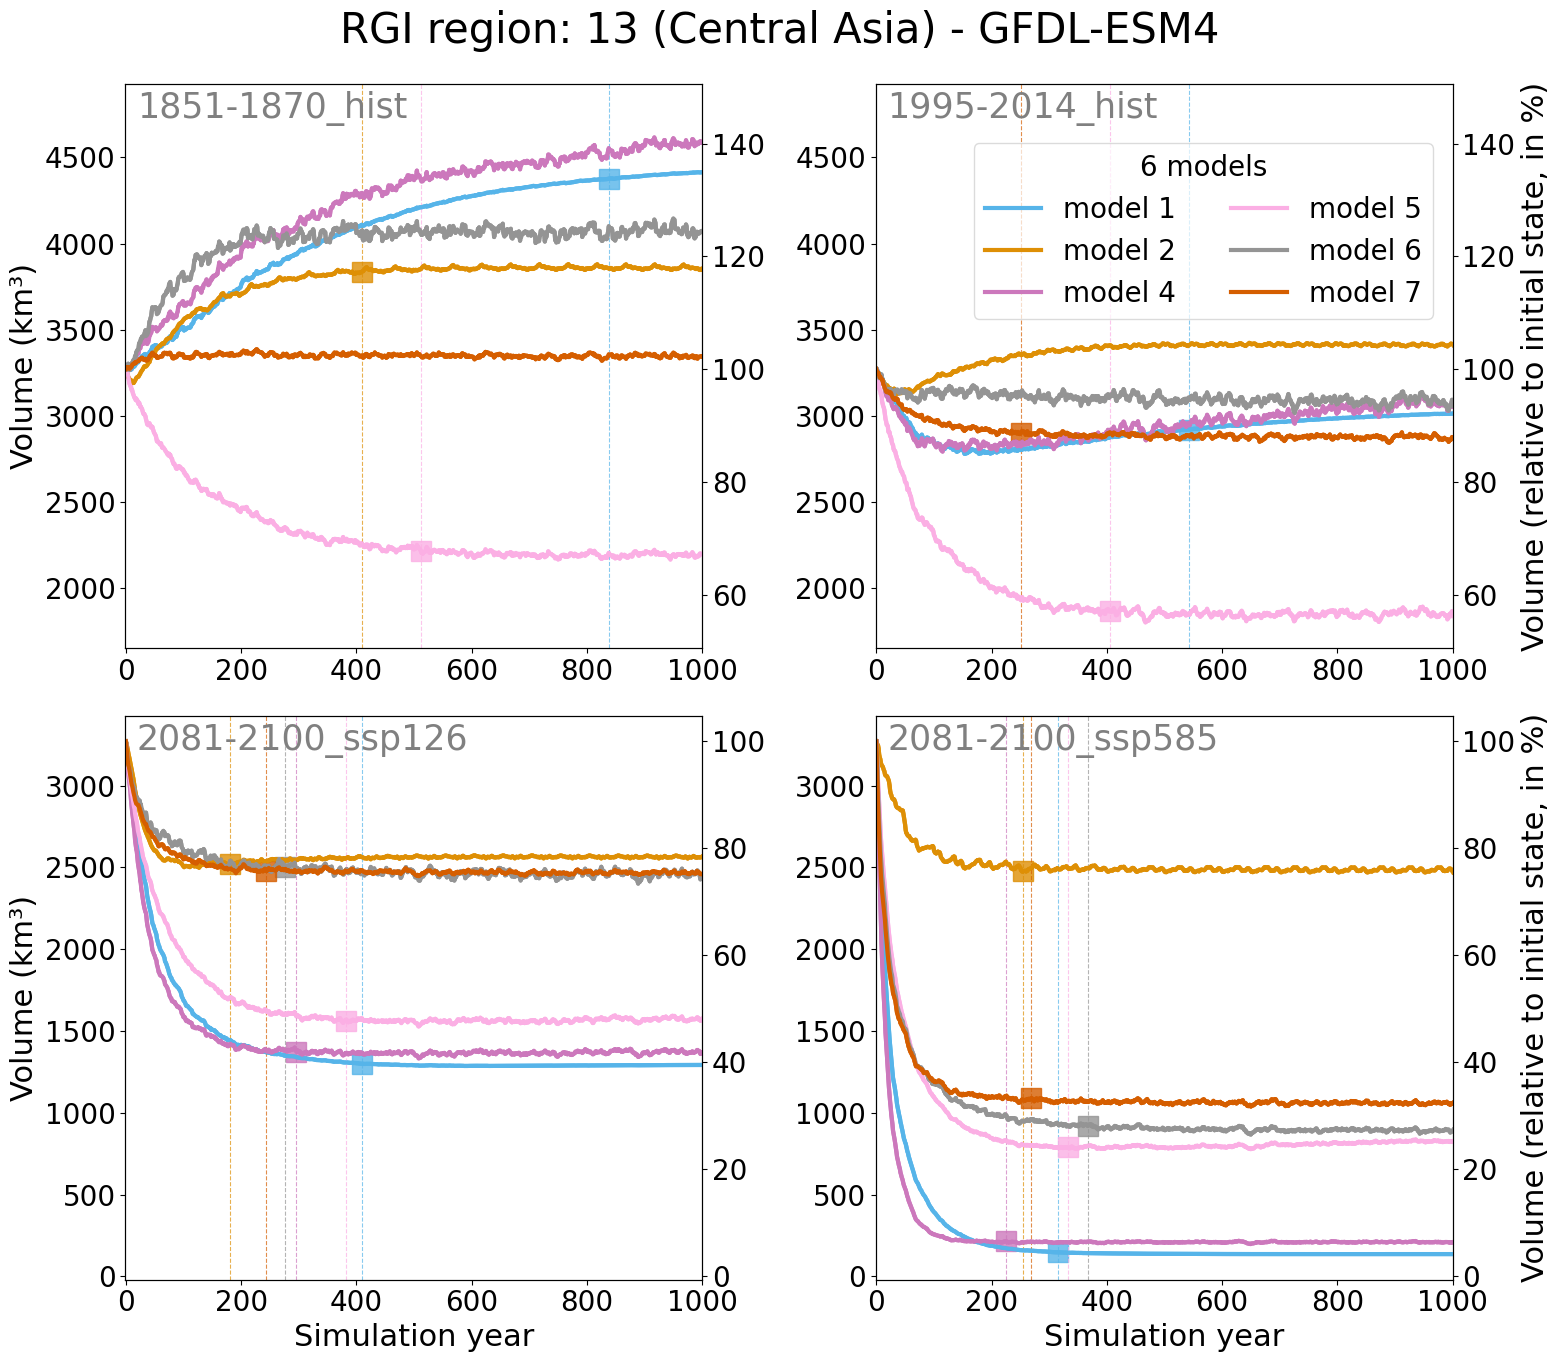

In [64]:
ls = 'solid'
sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
for anonym in ['_anonym']: #'', 
    for gcm in [ds_reg_models.gcm.values[0]]:
        #for rgi_reg in ['11']:
        for rgi_reg in ['13']:
            plt.figure(figsize=(16,14))
            axs = []
            for j,period_scenario in enumerate(sel_periods):
                if j==0 or j==2:
                    ax0=plt.subplot(2,2,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(2,2,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(),
                                 palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(),
                                 palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,2]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Simulation year', fontsize=22)

                ax.set_xlim([-1,1000])
                if j==1:
                    minip, maxip = ax.get_ylim()
                elif j==3:
                    minif, maxif = ax.get_ylim()
                
                pd_ss_m = pd_ss.loc[(gcm,period_scenario)]
                print(pd_ss_m)
                for m,c in zip(dict_model_col.keys(),dict_model_col.values()):
                    yr = pd_ss_m.loc[pd_ss_m.model_author==m]['simulation_year'].values#[0]
                    if len(yr)==1:
                        yr = yr[0]
                        pd_vol_reg_m_sel = pd_reg_vol_sel.loc[pd_reg_vol_sel.model_author==m]

                        y = pd_vol_reg_m_sel.loc[pd_vol_reg_m_sel.simulation_year==yr]['volume (km³)'].values.squeeze()
                        #print(m,yr,y)
                        #if len(y)==1:
                        plt.plot([yr], [y], 's',color=c, ms=15, alpha = 0.8)
                        plt.axvline([yr], color=c, alpha = 0.7,lw=0.8, ls='--')


            for j,period_scenario in enumerate(sel_periods):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [1,3]:
                    ax2.set_ylabel('Volume (relative to initial state, in %)', fontsize=22)
                    #ax.set_yticklabels([])
                else:
                    ax2.set_ylabel('')
                    #ax2.set_yticklabels([])

                if j==1: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.94, str(period_scenario), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)
                    

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<2:
                    ax2.set_ylim([minip*rel,maxip*rel])
                    ax.set_xlabel('')
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])

            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_w_steady_state.png')


/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
/tmp/ipykernel_4018227/2865016717.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(gcm,str(period

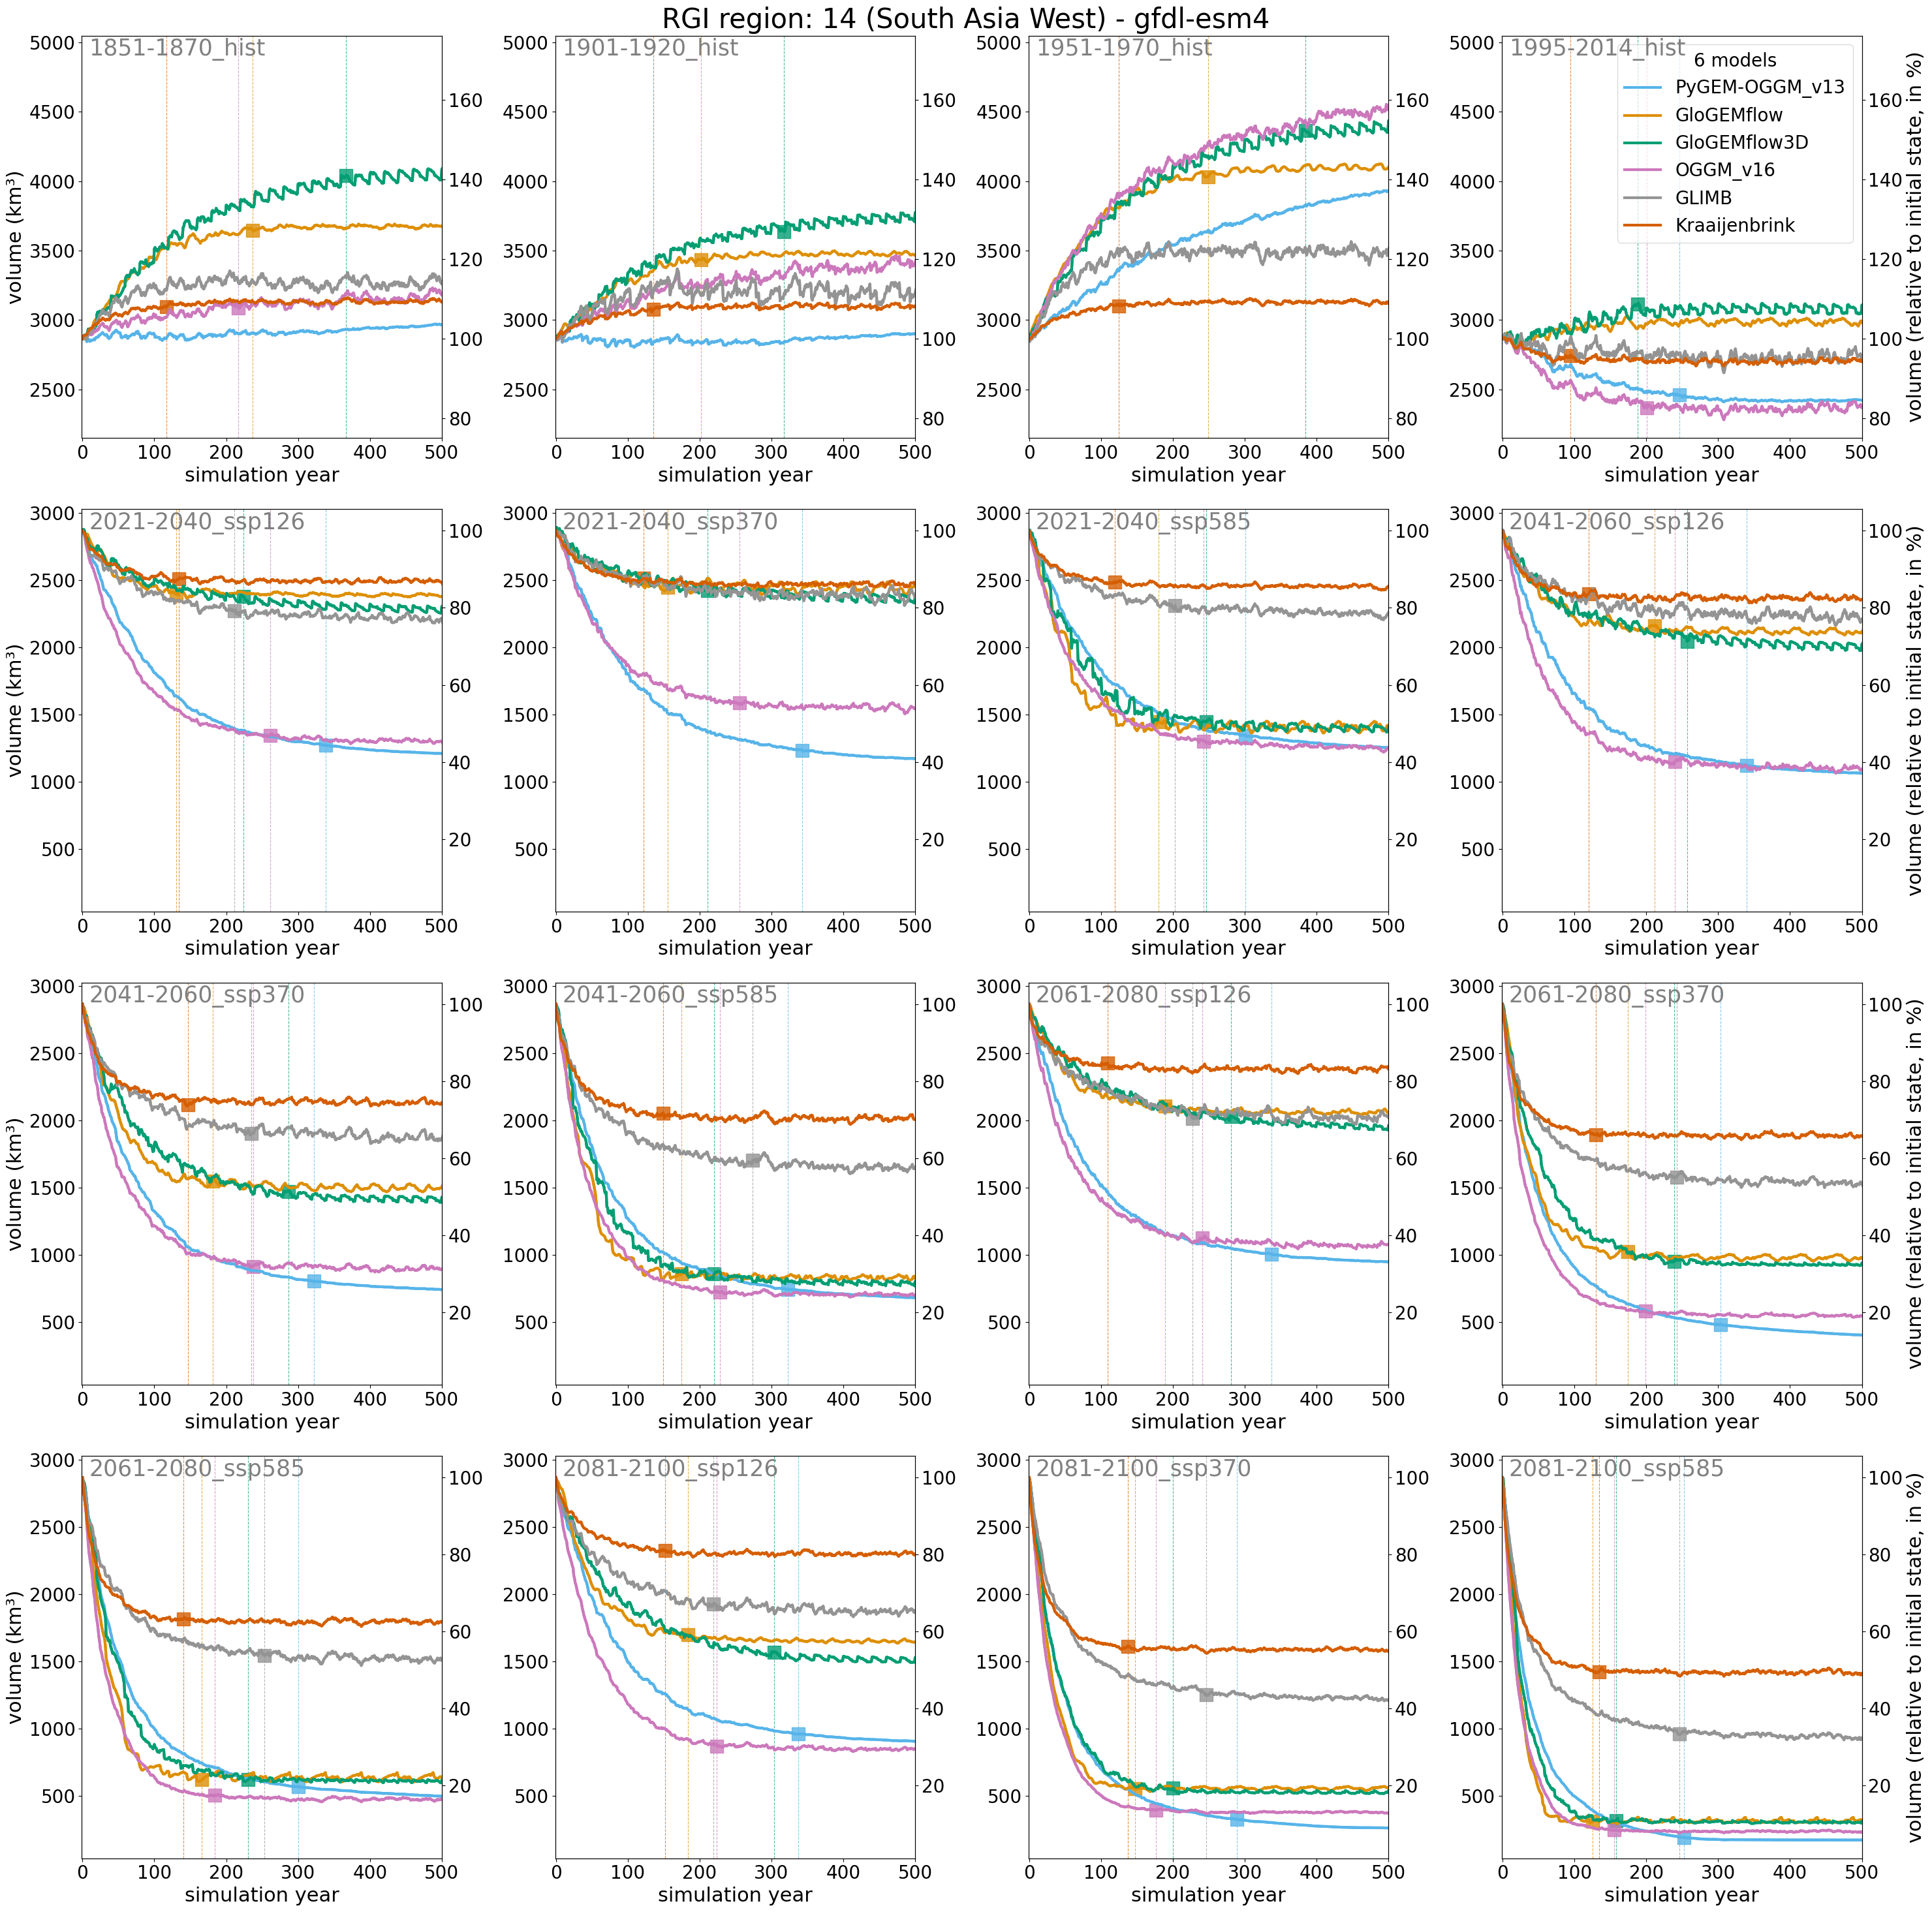

In [12]:
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
init_vol = ds_reg_models_vol.isel(simulation_year=0)
threshold_total_change = 5
avg_yrs=100
min_periods=20
xperc = 0.5
option='relative_to_total_change'
# make a rolling average over 100 years, but allow minimum 20 years to compute the estimates 
#ds_reg_models_vol_roll_threshold_total_change=yrs = 100*ds_reg_models.volume.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol

ls = 'solid'
for anonym in ['']: #'', 
    for gcm in [ds_reg_models.gcm.values[0]]:
        #for rgi_reg in ['11']:
        for rgi_reg in ['14']:
            _pd_ss_l = []
            for m in ds_reg_models_vol.model_author.values:
                _s_m = (ds_reg_models_vol/init_vol).sel(rgi_reg=rgi_reg).sel(model_author=m).dropna(dim='simulation_year')
                try:
                    ds_sel = 100*_s_m.rolling(simulation_year=avg_yrs, center=True, min_periods=min_periods).mean().dropna(dim='simulation_year')
                    _ss = compute_steady_state_yr(ds_sel, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods, option=option, test=True)
                except:
                    _ss = compute_steady_state_yr(_s_m, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods, option=option, test=True)
                _pd_ss = pd.DataFrame(_ss)
                _pd_ss['model_author'] = m
                _pd_ss_l.append(_pd_ss)
            pd_ss = pd.concat(_pd_ss_l)
            
            
            plt.figure(figsize=(30,30))
            axs = []
            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                if j==0 or j==4:
                    ax0=plt.subplot(4,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(4,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12]:
                    plt.ylabel('volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('simulation year', fontsize=22)

                ax.set_xlim([-1,500])
                if j==3:
                    minip, maxip = ax.get_ylim()
                elif j==15:
                    minif, maxif = ax.get_ylim()
                    
                    
                pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
                for m,c in zip(dict_model_col.keys(),dict_model_col.values()):
                    yr = pd_ss_m.loc[pd_ss_m.model_author==m]['simulation_year'].values#[0]
                    if len(yr)==1:
                        yr = yr[0]
                        pd_vol_reg_m_sel = pd_reg_vol_sel.loc[pd_reg_vol_sel.model_author==m]

                        y = pd_vol_reg_m_sel.loc[pd_vol_reg_m_sel.simulation_year==yr]['volume (km³)'].values.squeeze()
                        #print(m,yr,y)
                        #if len(y)==1:
                        plt.plot([yr], [y], 's',color=c, ms=15, alpha = 0.8)
                        plt.axvline([yr], color=c, alpha = 0.7,lw=0.8, ls='--')



            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                    
                    
                if j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5


                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<4:
                    ax2.set_ylim([minip*rel,maxip*rel])
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])

            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}.png')


In [11]:
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
init_vol = ds_reg_models_vol.isel(simulation_year=0)
threshold_total_change = 25 #0
avg_yrs=100
min_periods=20
# make a rolling average over 100 years, but allow minimum 20 years to compute the estimates 
#ds_reg_models_vol_roll_threshold_total_change=yrs = 100*ds_reg_models.volume.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol
xperc = 0.5 # 2

In [ ]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:
        _pd_ss_l = []
        for m in ds_reg_models_vol.model_author.values:
            _s_m = (ds_reg_models_vol/init_vol).sel(rgi_reg=rgi_reg).sel(model_author=m).dropna(dim='simulation_year')
            try:
                ds_sel = 100*_s_m.rolling(simulation_year=avg_yrs, center=True, min_periods=min_periods).mean()
                _ss = compute_steady_state_yr(ds_sel, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods)
            except:
                _ss = compute_steady_state_yr(_s_m, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods)
            _pd_ss = pd.DataFrame(_ss)
            _pd_ss['model_author'] = m
            _pd_ss_l.append(_pd_ss)
        pd_ss = pd.concat(_pd_ss_l)
        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,ds_reg_models.gcm):
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9

                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                if j in [0,4,8,12]:
                    ax.set_ylabel('volume (km³)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


                        

                #leg.set_bbox_to_anchor([1,1])
            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])
            
            pd_ss_m = pd_ss.loc[(str(gcm.values),str(period_scenario.values))]
            for m,c in zip(dict_model_col.keys(),dict_model_col.values()):
                yr = pd_ss_m.loc[pd_ss_m.model_author==m]['simulation_year'].values#[0]
                if len(yr)==1:
                    yr = yr[0]
                    pd_vol_reg_m_sel = pd_reg_vol_sel.loc[pd_reg_vol_sel.model_author==m]

                    y = pd_vol_reg_m_sel.loc[pd_vol_reg_m_sel.simulation_year==yr]['volume (km³)'].values.squeeze()
                    #print(m,yr,y)
                    #if len(y)==1:
                    plt.plot([yr], [y], 's',color=c, ms=15, alpha = 0.8)
                    plt.axvline([yr], color=c, alpha = 0.7,lw=0.8, ls='--')

        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            ax = axs[j]
            ax2 = ax.twinx()
            for ls,gcm in zip(ls_l,ds_reg_models.gcm):
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                        
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2, zorder=2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2, zorder=2)
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                
                
                if ls == 'solid' and j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
            
            
            rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
            rel = rel.dropna(dim='model_author')
            np.testing.assert_allclose(rel[0], rel)
            rel = rel[0].values

            if j<4:
                ax2.set_ylim([minip*rel,maxip*rel])
            else:
                ax2.set_ylim([minif*rel,maxif*rel])
        
            ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax2.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/vol_time_series_rgi_reg{rgi_reg}{anonym}.png')
        plt.close()

- plots separately for every GCM:

In [12]:
ls = 'solid'
for anonym in ['', '_anonym']:
    for gcm in ds_reg_models.gcm.values:
        #for rgi_reg in ['11']:
        for rgi_reg in rgi_regs:
            _pd_ss_l = []
            for m in ds_reg_models_vol.model_author.values:
                _s_m = (ds_reg_models_vol/init_vol).sel(rgi_reg=rgi_reg).sel(model_author=m).dropna(dim='simulation_year')
                try:
                    ds_sel = 100*_s_m.rolling(simulation_year=avg_yrs, center=True, min_periods=min_periods).mean()
                    _ss = compute_steady_state_yr(ds_sel, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods)
                except:
                    _ss = compute_steady_state_yr(_s_m, xperc=xperc, threshold_total_change=threshold_total_change, minimum_period=min_periods)
                _pd_ss = pd.DataFrame(_ss)
                _pd_ss['model_author'] = m
                _pd_ss_l.append(_pd_ss)
            pd_ss = pd.concat(_pd_ss_l)
            
            plt.figure(figsize=(30,30))
            axs = []
            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                if j==0 or j==4:
                    ax0=plt.subplot(4,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(4,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12]:
                    plt.ylabel('volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('simulation year', fontsize=22)

                ax.set_xlim([-100,2000])
                if j==3:
                    minip, maxip = ax.get_ylim()
                elif j==15:
                    minif, maxif = ax.get_ylim()

                #pd_ss_m = pd_ss.loc[(gcm,str(period_scenario.values))]
                pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
                for m,c in zip(dict_model_col.keys(),dict_model_col.values()):
                    yr = pd_ss_m.loc[pd_ss_m.model_author==m]['simulation_year'].values#[0]
                    if len(yr)==1:
                        yr = yr[0]
                        pd_vol_reg_m_sel = pd_reg_vol_sel.loc[pd_reg_vol_sel.model_author==m]

                        y = pd_vol_reg_m_sel.loc[pd_vol_reg_m_sel.simulation_year==yr]['volume (km³)'].values.squeeze()
                        #print(m,yr,y)
                        #if len(y)==1:
                        plt.plot([yr], [y], 's',color=c, ms=15, alpha = 0.8)
                        plt.axvline([yr], color=c, alpha = 0.7,lw=0.8, ls='--')

            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                    
                    
                if j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5


                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)
                    
                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<4:
                    ax2.set_ylim([minip*rel,maxip*rel])
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])
                if j<12:
                    ax.set_xlabel('')
            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_{DATE}.png')
            plt.close()

/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(str(gcm),str(period_scenario.values))]
/tmp/ipykernel_488009/920999117.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd_ss_m = pd_ss.loc[(s

In [2]:
import pandas as pd

In [3]:
pd.read_html('/home/www/oggm/cmip6/all_gcm_table.html')[0]

Unnamed: 0         folder                                fname  \
0            46     ACCESS-CM2     ACCESS-CM2_ssp126_r1i1p1f1_pr.nc   
1            49     ACCESS-CM2    ACCESS-CM2_ssp126_r1i1p1f1_tas.nc   
2            47     ACCESS-CM2     ACCESS-CM2_ssp585_r1i1p1f1_pr.nc   
3            48     ACCESS-CM2    ACCESS-CM2_ssp585_r1i1p1f1_tas.nc   
4            39  ACCESS-ESM1-5  ACCESS-ESM1-5_ssp126_r1i1p1f1_pr.nc   
..          ...            ...                                  ...   
141          34     NorESM2-MM    NorESM2-MM_ssp370_r1i1p1f1_tas.nc   
142          29     NorESM2-MM     NorESM2-MM_ssp585_r1i1p1f1_pr.nc   
143          33     NorESM2-MM    NorESM2-MM_ssp585_r1i1p1f1_tas.nc   
144          44        TaiESM1        TaiESM1_ssp585_r1i1p1f1_pr.nc   
145          45        TaiESM1       TaiESM1_ssp585_r1i1p1f1_tas.nc   

               gcm     ssp       rea  var  resolution    y0    y1  
0       ACCESS-CM2  ssp126  r1i1p1f1   pr        1.88  1850  2300  
1       ACCESS-CM2  ssp126  r1i1p1f1  tas        1.88  1850  2300  
2       ACCESS-CM2  ssp585  r1i1p1f1   pr        1.88  1850  2300  
3       ACCESS-CM2  ssp585  r1i1p1f1  tas        1.88  1850  2300  
4    ACCESS-ESM1-5  ssp126  r1i1p1f1   pr        1.88  1850  2300  
..             ...     ...       ...  ...         ...   ...   ...  
141     NorESM2-MM  ssp370  r1i1p1f1  tas        1.25  1850  2100  
142     NorESM2-MM  ssp585  r1i1p1f1   pr        1.25  1850  2100  
143     NorESM2-MM  ssp585  r1i1p1f1  tas        1.25  1850  2100  
144        TaiESM1  ssp585  r1i1p1f1   pr        1.25  1850  2100  
145        TaiESM1  ssp585  r1i1p1f1  tas        1.25  1850  2100  

[146 rows x 10 columns]

### Plot the thinning rates (kg m-2 yr-1)
- what should be done if the glacier regions is almost gone (should a MB estimate still be estimated??

$$B(yr) = \frac{V(yr)- V(yr-1)}{2\cdot(A(yr)+A(yr-1))}$$

In [55]:
# thinning rate: 
# V(t1 / Aavg 
init_area = ds_reg_models.area_m2.sel(simulation_year=0)
deltaV = ds_reg_models.volume_m3.sel(simulation_year=slice(1,5000))-ds_reg_models.volume_m3.sel(simulation_year=slice(0,4999)).values
Aavg = 0.5* (ds_reg_models.area_m2.sel(simulation_year=slice(1,5000))+ds_reg_models.area_m2.sel(simulation_year=slice(0,4999)).values)
Aavg = Aavg.where(Aavg/init_area>0.005)# only compute thtat if region has above 0.5% of initial area (otherwise we get too much noise ... )
ds_specific_mb = deltaV/Aavg # m w.e. (kg m-2 yr-1), Attention we do not want to divide through zero 
ds_specific_mb_roll = ds_specific_mb.rolling(simulation_year=20, center=True).mean()
ds_specific_mb_roll

<xarray.DataArray (model_author: 9, gcm: 5, rgi_reg: 19, simulation_year: 5000,
                   period_scenario: 16)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * model_author     (model_author) object 'Rounce' 'Compagno' ... 'CISM2'
  * simulation_year  (simulation_year) int16 1 2 3 4 5 ... 4997 4998 4999 5000
  * gcm              (gcm) object 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'
  * rgi_reg          (rgi_reg) object '01' '02' '03' '04' ... '17' '18' '19'
  * period_scenario  (period_scenario) object '1851-1870_hist' ... '2081-2100...

***Manuscript***

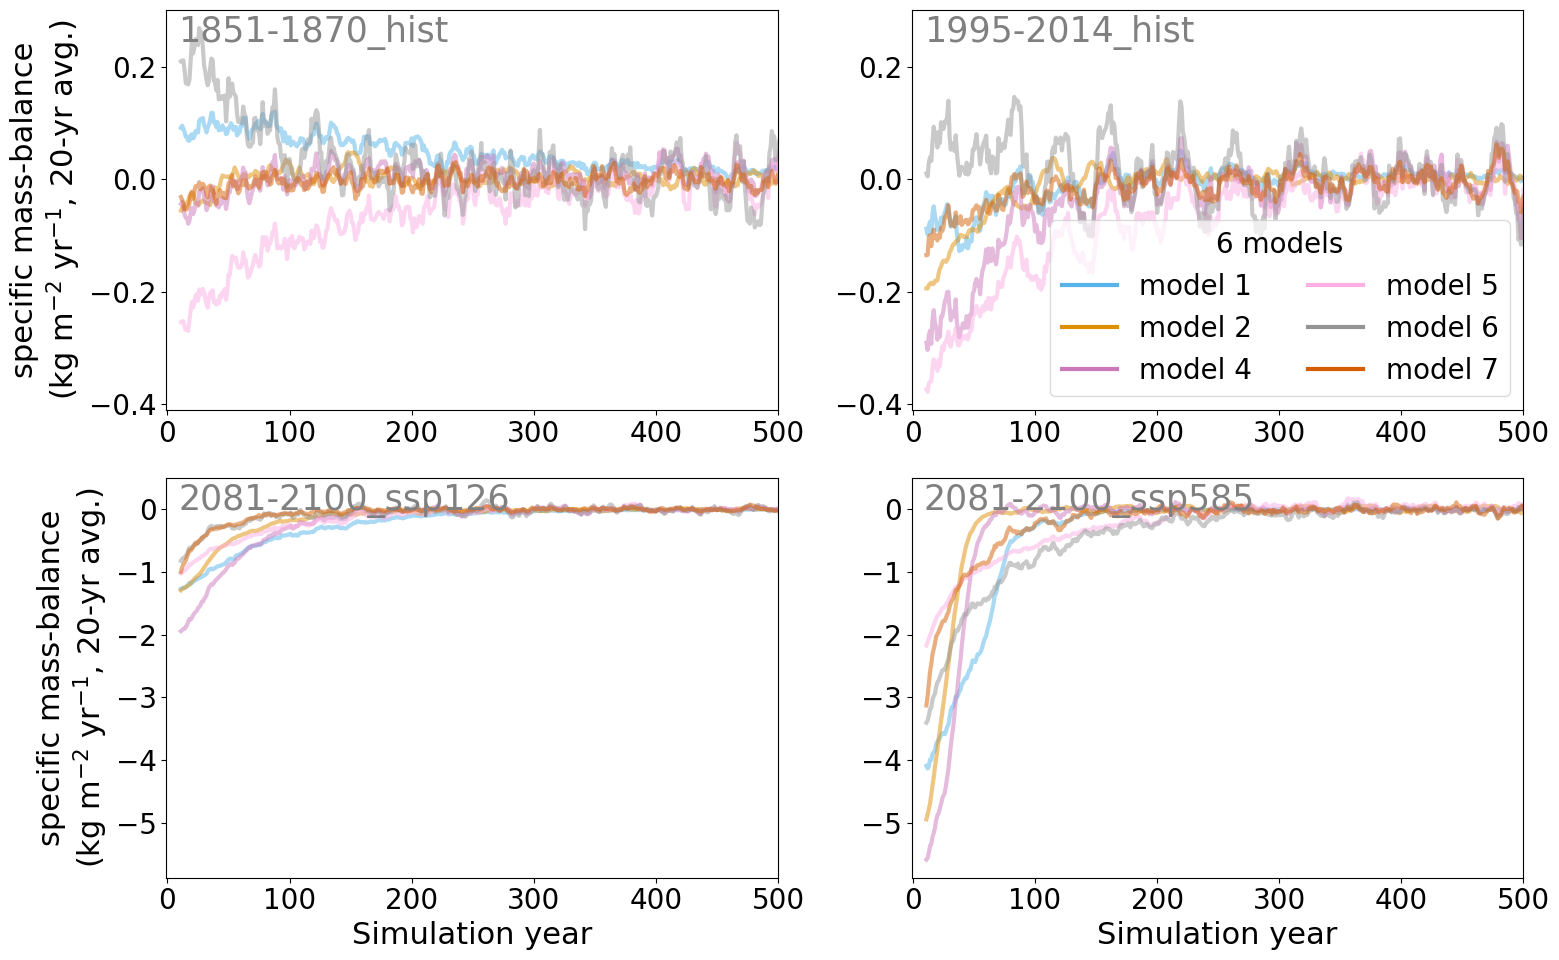

In [66]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in ['13']:

        axs = []
        plt.figure(figsize=(16,10))
        for j,period_scenario in enumerate(sel_periods):
            if j==0 or j==2:
                ax0=plt.subplot(2,2,j+1)
                ax = ax0
            else:
                ax=plt.subplot(2,2,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[-1]]):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='lower right', framealpha = 0.7, ncol=2)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,2]:
                    ax.set_ylabel('specific mass-balance\n'+r'(kg m$^{-2}$ yr$^{-1}$, 20-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                if j<2:
                    ax.set_xlabel('')
                else:
                    ax.set_xlabel('Simulation year', fontsize=22)


            minip, maxip = ax.get_ylim()

            ax.set_xlim([-1,500])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.92, str(period_scenario), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        #plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/manuscript_spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_{gcm}.png')


- just check the last year:

In [147]:
pd_specific_mb_roll = ds_specific_mb_roll.dropna(dim='simulation_year', how='all').isel(simulation_year=-1).to_dataframe('specific_mb')

In [148]:
pd_specific_mb_roll_t = pd_specific_mb_roll.reset_index().groupby(['model_author', 'period_scenario']).median().dropna()

In [149]:
pd_specific_mb_roll.loc[np.abs(pd_specific_mb_roll.specific_mb)>0.01].reset_index().groupby('model_author').count()

gcm  rgi_reg  period_scenario  simulation_year  specific_mb
model_author                                                             
Compagno      172      172              172              172          172
GLIMB          77       77               77               77           77
James          57       57               57               57           57
OGGM-VAS      218      218              218              218          218
OGGM_v16      138      138              138              138          138
Rounce         77       77               77               77           77

- now check the average specific MB over 500 years, is it near zero?
    - RGI08: Zekollari, ipsl-cm6a-lr (2081-2100_ssp370, 2081-2100_ssp585) and ukesm1-0-ll (2041-2060_ssp370)-> there is sth. strange!!!

In [150]:
pd_specific_mb_roll_mean= ds_specific_mb_roll.dropna(dim='simulation_year', how='all').sel(simulation_year=slice(1450,1950)).mean(dim='simulation_year').to_dataframe('specific_mb_mean_100yr_avg')

In [151]:
pd_specific_mb_roll_mean = pd_specific_mb_roll_mean.dropna()

In [152]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.01].reset_index().groupby('model_author').count().sort_values(by='specific_mb_mean_100yr_avg')

gcm  rgi_reg  period_scenario  specific_mb_mean_100yr_avg
model_author                                                           
Zekollari      14       14               14                          14
OGGM-VAS      112      112              112                         112
Compagno      209      209              209                         209
Rounce        283      283              283                         283
GLIMB         449      449              449                         449
OGGM_v16      562      562              562                         562

In [153]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.01].reset_index().groupby(['model_author']).max()#.#sort_values(by='specific_mb_mean_100yr_avg')

gcm rgi_reg   period_scenario  \
model_author                                          
Compagno      ukesm1-0-ll      19  2081-2100_ssp585   
GLIMB         ukesm1-0-ll      19  2081-2100_ssp585   
OGGM-VAS      ukesm1-0-ll      18  2081-2100_ssp585   
OGGM_v16      ukesm1-0-ll      19  2081-2100_ssp585   
Rounce        ukesm1-0-ll      19  2081-2100_ssp585   
Zekollari     ukesm1-0-ll      18  2081-2100_ssp585   

              specific_mb_mean_100yr_avg  
model_author                              
Compagno                        0.162207  
GLIMB                          -0.010016  
OGGM-VAS                        0.081617  
OGGM_v16                        0.090120  
Rounce                          0.082060  
Zekollari                       0.807498

In [157]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.2]#.#sort_values(by='specific_mb_mean_100yr_avg')

specific_mb_mean_100yr_avg
model_author gcm           rgi_reg period_scenario                             
Zekollari    mri-esm2-0    08      2041-2060_ssp126                    0.807498
OGGM_v16     mpi-esm1-2-hr 08      2061-2080_ssp370                   -0.234773
GLIMB        gfdl-esm4     09      2041-2060_ssp370                   -0.264262
                                   2041-2060_ssp585                   -0.238884
                                   2061-2080_ssp126                   -0.206358
             ipsl-cm6a-lr  09      2041-2060_ssp126                   -0.528460
                                   2081-2100_ssp126                   -0.490451
             mpi-esm1-2-hr 09      2041-2060_ssp370                   -0.244066
                                   2061-2080_ssp370                   -0.353979
                                   2061-2080_ssp585                   -0.350478
             mri-esm2-0    09      2021-2040_ssp585                   -0.234330
                                   2041-2060_ssp126                   -0.298733
                                   2041-2060_ssp370                   -0.399823
                                   2061-2080_ssp126                   -0.449704
             ukesm1-0-ll   09      2021-2040_ssp126                   -0.327903
                                   2021-2040_ssp585                   -0.472068

In [158]:
pd_specific_mb_roll_std = ds_specific_mb_roll.dropna(dim='simulation_year', how='all').sel(simulation_year=slice(1450,1950)).std(dim='simulation_year').to_dataframe('specific_mb_std_100yr_avg')

 is there a pattern in which models wobble around and which not??? I checked the standard deviation of the 100 yr average specific MB for the last 500 yrs... 
 - the largest std. of specific MB occur  for the models: James, GLIMB, OGGM-VAS, but there is some variability also in OGGM_v16 and CI

In [159]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.01].reset_index().groupby('model_author').max().sort_values(by='specific_mb_std_100yr_avg')

gcm rgi_reg   period_scenario  \
model_author                                           
Kraaijenbrink  ukesm1-0-ll      15  2081-2100_ssp585   
CISM2          ukesm1-0-ll      11  2081-2100_ssp585   
Rounce         ukesm1-0-ll      19  2081-2100_ssp585   
Compagno       ukesm1-0-ll      19  2081-2100_ssp585   
GLIMB          ukesm1-0-ll      19  2081-2100_ssp585   
OGGM_v16       ukesm1-0-ll      19  2081-2100_ssp585   
OGGM-VAS       ukesm1-0-ll      18  2081-2100_ssp585   
James          ukesm1-0-ll      06  2081-2100_ssp585   

               specific_mb_std_100yr_avg  
model_author                              
Kraaijenbrink                   0.018926  
CISM2                           0.024595  
Rounce                          0.028411  
Compagno                        0.036873  
GLIMB                           0.039583  
OGGM_v16                        0.040370  
OGGM-VAS                        0.069099  
James                           0.129646

In [162]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.03].reset_index().groupby('model_author').count()

gcm  rgi_reg  period_scenario  specific_mb_std_100yr_avg
model_author                                                          
Compagno        1        1                1                          1
GLIMB          28       28               28                         28
James          76       76               76                         76
OGGM-VAS      179      179              179                        179
OGGM_v16       27       27               27                         27

In [165]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.1]

specific_mb_std_100yr_avg
model_author gcm          rgi_reg period_scenario                            
James        ipsl-cm6a-lr 06      2041-2060_ssp585                   0.103562
                                  2061-2080_ssp585                   0.129646
                                  2081-2100_ssp585                   0.107311
             ukesm1-0-ll  06      1995-2014_hist                     0.110533
                                  2021-2040_ssp126                   0.106196

In [166]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.01].reset_index().groupby('model_author').count().sort_values(by='specific_mb_std_100yr_avg')

gcm  rgi_reg  period_scenario  specific_mb_std_100yr_avg
model_author                                                           
Compagno        25       25               25                         25
Kraaijenbrink   47       47               47                         47
Rounce          47       47               47                         47
CISM2           64       64               64                         64
James           76       76               76                         76
GLIMB          795      795              795                        795
OGGM-VAS       829      829              829                        829
OGGM_v16       903      903              903                        903

In [168]:
t = pd_specific_mb_roll_std.reset_index().dropna()
t.loc[t.model_author=='CISM2'].max()

model_author                            CISM2
gcm                               ukesm1-0-ll
rgi_reg                                    11
period_scenario              2081-2100_ssp585
specific_mb_std_100yr_avg            0.024595
dtype: object

In [ ]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:

        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,ds_specific_mb.gcm):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,4,8,12]:
                    ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}.png')
        plt.close()

In [180]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:

        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[0]]):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,4,8,12]:
                    ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_gfdl-esm4.png')
        plt.close()

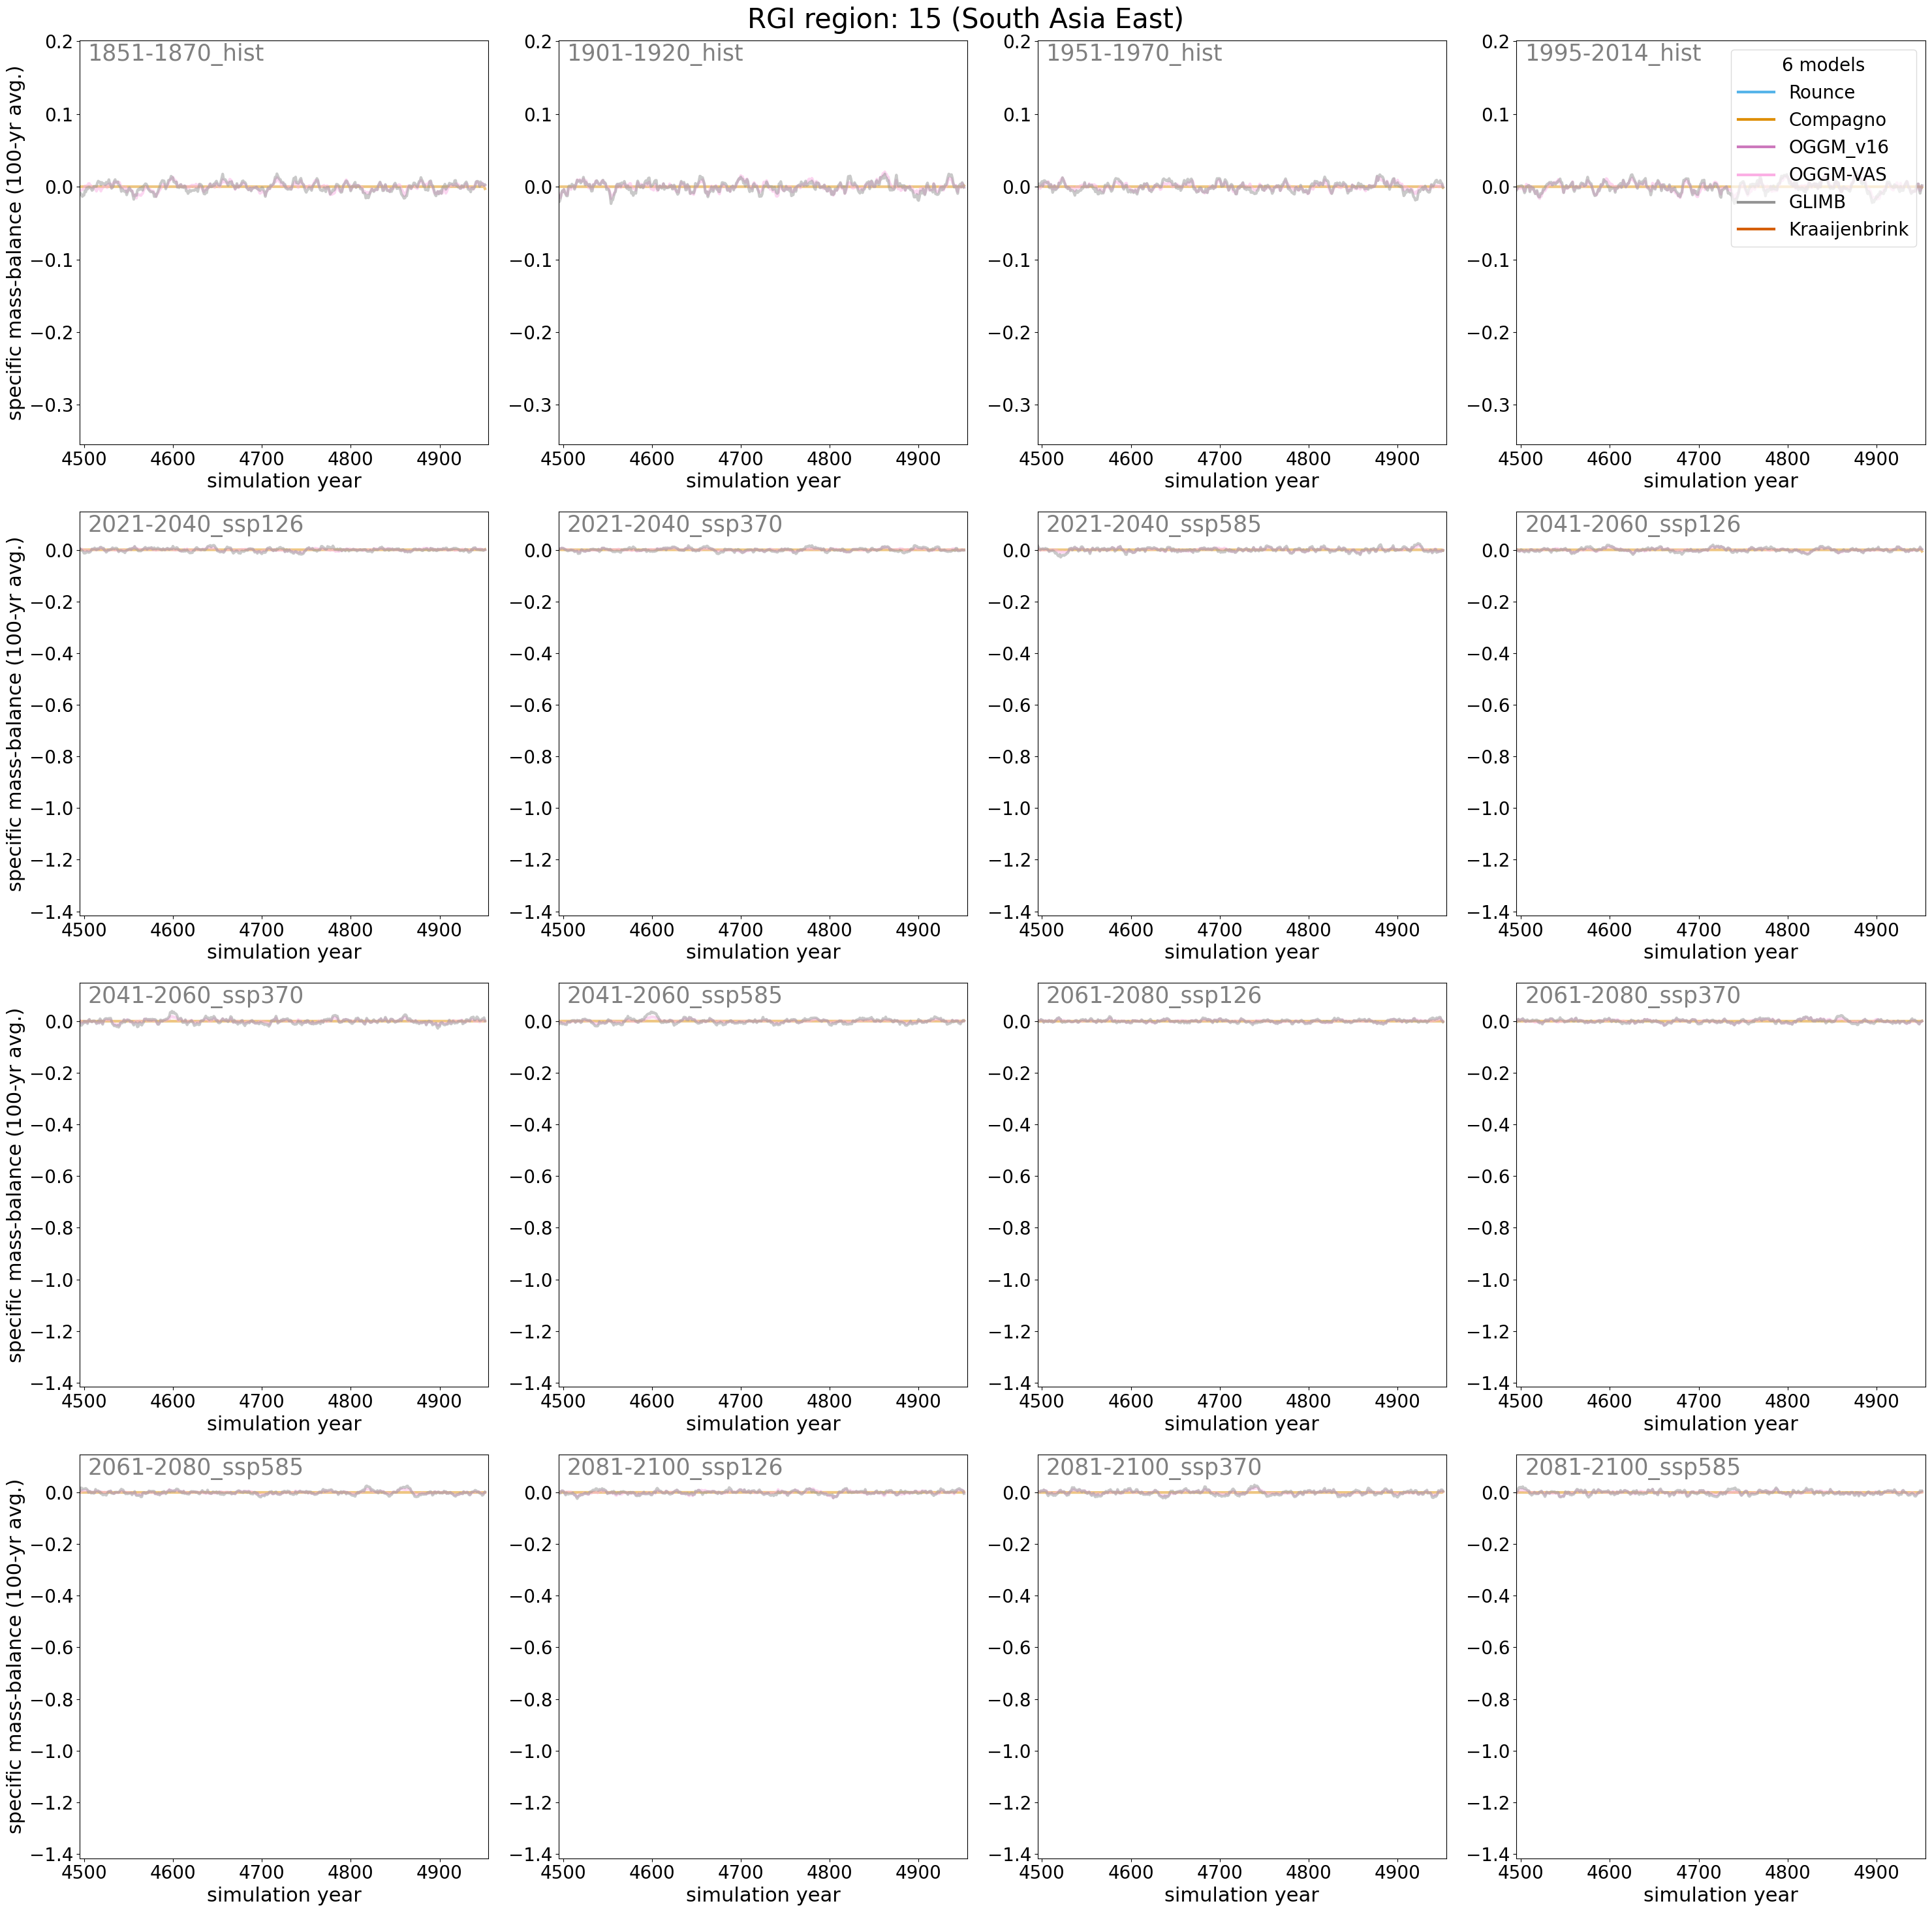

In [179]:
# just check the last 1000 years 
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
#for anonym in ['', '_anonym']:
#for rgi_reg in ['11']:
#for rgi_reg in rgi_regs:
rgi_reg = '15'
axs = []
anonym = ''
plt.figure(figsize=(30,30))
for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
    if j==0 or j==4:
        ax0=plt.subplot(4,4,j+1)
        ax = ax0
    else:
        ax=plt.subplot(4,4,j+1,sharey=ax0)
    axs.append(ax)
    for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[0]]):
        pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
        pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()

        # get  regional models and correct color, anonym model number 
        # to  get a legend with only the models of that region... 
        models_reg = pd_reg_spec_mb_sel.model_author.unique()
        dict_model_col_reg = {}
        list_reg_model_anonym = []
        for h, p in zip(hue_order,pal_models):
            if h in models_reg:
                dict_model_col_reg[h]= p
                list_reg_model_anonym.append(model_order_anonymous[h])

        if ls == 'solid' and j==3:
            sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                     hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
            _leg = ax.get_legend()
            handles, labels = ax.get_legend_handles_labels()
            _leg.remove()
            n = len(models_reg)
            if anonym:
                leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
            else:
                leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
            leg.set_zorder = 2.5
        else:
            sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                     hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
        if j in [0,4,8,12]:
            ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('simulation year', fontsize=22)


    if j==3:
        minip, maxip = ax.get_ylim()
    elif j==15:
        minif, maxif = ax.get_ylim()

    ax.set_xlim([4495,4955])            

    #if j<4:
    #    ax2.set_ylim([minip*rel,maxip*rel])
    #else:
    #    ax2.set_ylim([minif*rel,maxif*rel])

    ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
            fontsize=25, transform=ax.transAxes, zorder=6)

reg = d_reg_num_name[rgi_reg]
plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
plt.tight_layout()

plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_gfdl-esm4_last_yrs.png')
#plt.close()

- e.g. in RGI04: GloGEMFlow has a non-zero positive MB from 4500 till the end for some experiments, similarly in one experiment in RGI06 ...
- James very variable in terms of specific mass balance 
- are they correlating between the different models???

- old: same plot again without UKESM

In [ ]:
old = False
if old:
    ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]

    for rgi_reg in rgi_regs:
        axs = []
        plt.figure(figsize=(30,40))
        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']):
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], y='volume (km³)',
                             hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend='brief', lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], y='volume (km³)',
                             hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend=False, lw=3, ax=ax)
                if j in [0,4,8,12]:
                    ax.set_ylabel('volume (km³)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)
                if ls == 'solid' and j==3: 
                    leg = ax.get_legend()
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                #leg.set_bbox_to_anchor([1,1])
            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_title(str(period_scenario.values))
            ax.set_xlim([-100,5100])

        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            ax = axs[j]
            ax2 = ax.twinx()
            for ls,gcm in zip(ls_l, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']):
                _ref = 100*ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3/ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], 
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], 
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend=False, lw=3, ax=ax2)
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

            rel = 100*1e9/ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).sel(simulation_year=0).volume_m3
            rel = rel.dropna(dim='model_author')
            np.testing.assert_allclose(rel[0], rel)
            rel = rel[0].values

            if j<4:
                ax2.set_ylim([minip*rel,maxip*rel])
            else:
                ax2.set_ylim([minif*rel,maxif*rel])


        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})')
        plt.tight_layout()

        plt.savefig(f'/home/www/lschuster/glacierMIP3_analysis/analysis_2023_03/no_ukesm/vol_time_series_rgi_reg{rgi_reg}.pdf')
        plt.close()